In [2]:


%matplotlib inline
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
# pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 4))
pd.set_option('display.max_columns', None) #输出所有列

def set_ch():
    from pylab import mpl
    #中文字体问题已经解决，记录在evernote中
    #mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
set_ch()
from datetime import datetime,timedelta
import matplotlib
matplotlib.style.use('ggplot')
import sys
import json

### 导入结果

In [3]:
import flatten_json
def engineFeature(filePath):
    # 读入txt
    f = open(filePath)
    fileContent = f.readlines()
    # 整理有用的字段为dataframe
    key_list = ['refText','result_accuracy','result_wavetime','result_overall','result_integrity',
                'result_fluency_overall','result_fluency_pause','result_fluency_speed',
                'result_rhythm_overall','result_rhythm_sense','result_rhythm_stress','result_rhythm_tone',
                'result_info_snr','result_info_volume','result_info_tipId']
    df_all = DataFrame(fileContent)
    all_li = [eval(DataFrame(fileContent).ix[i,:].values[0]) for i in range(len(df_all))]
    fea_li = []
    for i in range(len(all_li)):
        res = flatten_json.flatten(all_li[i])
        fea_li.append({fea:value for fea,value in res.items() if fea in key_list})
    df_engine = DataFrame(fea_li)
    return df_engine

In [4]:
%time df_engine = engineFeature('data/result.txt')

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


CPU times: user 47.5 s, sys: 6.43 s, total: 54 s
Wall time: 55.8 s


In [3]:
df_engine = pd.read_csv('data/engineDetails.csv').drop(['Unnamed: 0'], axis=1)

In [4]:
# 去除NA的记录
df_engine = df_engine.dropna(axis=0,how='any')
df_engine = df_engine.reset_index().drop(['index'],axis=1)

In [5]:
df_engine

,refText,result_accuracy,result_fluency_overall,result_fluency_pause,result_fluency_speed,result_info_snr,result_info_tipId,result_info_volume,result_integrity,result_overall,result_rhythm_overall,result_rhythm_sense,result_rhythm_stress,result_rhythm_tone,result_wavetime
0,This is my grandma.,57.0,44.0,0.0,0.0,7.533660,0.0,90.0,60.0,46.0,13.0,0.0,50.0,0.0,3720.0
1,This is my uncle.,89.0,51.0,0.0,0.0,6.951506,0.0,89.0,100.0,80.0,38.0,50.0,50.0,0.0,3820.0
2,This is my uncle.,93.0,52.0,0.0,0.0,14.115746,0.0,95.0,100.0,85.0,38.0,50.0,50.0,0.0,4230.0
3,Do you like tigers?,75.0,82.0,0.0,1.0,11.383710,0.0,91.0,80.0,60.0,100.0,100.0,100.0,100.0,4140.0
4,Look at the lion.,50.0,54.0,1.0,0.0,15.240611,0.0,96.0,60.0,56.0,19.0,0.0,75.0,0.0,3920.0
5,I can see a panda.,91.0,64.0,0.0,0.0,19.142456,0.0,100.0,100.0,89.0,65.0,100.0,60.0,0.0,3740.0
6,What are the rules?,78.0,56.0,0.0,0.0,20.817936,0.0,99.0,80.0,68.0,75.0,100.0,100.0,0.0,4830.0
7,"""Well, we can't arrive late for class. We must...",89.0,77.0,0.0,1.0,10.359365,0.0,90.0,100.0,88.0,15.0,0.0,58.0,0.0,6940.0
8,Don't eat in the classroom. You must eat in th...,63.0,74.0,1.0,1.0,2.301756,10006.0,91.0,69.0,56.0,21.0,0.0,83.0,0.0,6130.0
9,What a pity!,97.0,90.0,0.0,1.0,16.432657,0.0,99.0,100.0,95.0,92.0,100.0,67.0,100.0,2430.0


### 各字段解释

![](img/params.png)

'refText': 文本  
'result_accuracy': 发音得分  
'result_wavetime': 音频时长  
'result_overall': 总分  
'result_integrity': 完整度评分  
'result_fluency_overall': 流利度总得分  
'result_fluency_pause': 停顿次数  
'result_fluency_speed': 语速，0慢，1正常，2快  
'result_rhythm_overall': 韵律总体得分（sense50%，stress25%，tone25%）  
'result_rhythm_sense': 意群得分(0-100)  
'result_rhythm_stress': 重音得分（0-100）  
'result_rhythm_tone': 升降掉得分（0-100）  
'result_info_snr': 信噪比，值越高越清晰（0-40）  
'result_info_volume': 录音音量（0-180）  
'result_info_tipId': 提示信息代码（eg,10002识别不完整，10005位置太近音频截幅等）  

### 统计特征

In [6]:
# 包含0的记录
abs_sent = {}
#'result_fluency_speed','result_info_tipId' 类别变量不计算
for column in ('result_accuracy','result_wavetime','result_overall','result_integrity',
                'result_fluency_overall','result_fluency_pause',
                'result_rhythm_overall','result_rhythm_sense','result_rhythm_stress','result_rhythm_tone',
                'result_info_snr','result_info_volume'):
   val_mean = eval('df_engine.' + column + '.mean()')
   val_median = eval('df_engine.' + column + '.median()')
   val_mode = eval('df_engine.' + column + '.mode().values')
   val_min = eval('df_engine.' + column + '.min()')
   val_max = eval('df_engine.' + column + '.max()')
   val_std = eval('df_engine.' + column + '.std()')
   val_CV = val_std / val_mean
   abs_sent[column] = [val_mean, val_median, val_mode, val_min, val_max, val_std, val_CV]
df_charac_0 = DataFrame(abs_sent)
df_charac_0.index = ['mean', 'median', 'mode', 'min', 'max', 'std','CV']

In [7]:
df_charac_0.T

,mean,median,mode,min,max,std,CV
result_accuracy,66.5658,75,[0.0],0,100,27.9527,0.419926
result_fluency_overall,56.9396,62,[0.0],0,100,26.0507,0.457514
result_fluency_pause,0.493524,0,[0.0],0,8,0.835921,1.69378
result_info_snr,10.9836,10.0424,[0.0],0,40,9.5852,0.87268
result_info_volume,89.5343,92,[96.0],2,113,12.9378,0.144501
result_integrity,67.8302,77,[100.0],0,100,33.6131,0.495548
result_overall,60.2176,69,[0.0],0,99,28.0692,0.46613
result_rhythm_overall,51.183,47,[50.0],0,100,22.8976,0.447368
result_rhythm_sense,39.6122,50,[0.0],0,100,41.7552,1.0541
result_rhythm_stress,61.6543,67,[100.0],0,100,29.707,0.481831


In [8]:
# 没有包含0的记录
abs_sent = {}
#'result_fluency_speed','result_info_tipId' 类别变量不计算
for column in ('result_accuracy','result_wavetime','result_overall','result_integrity',
                'result_fluency_overall','result_fluency_pause',
                'result_rhythm_overall','result_rhythm_sense','result_rhythm_stress','result_rhythm_tone',
                'result_info_snr','result_info_volume'):
   val_mean = eval('df_engine[df_engine.' + column + '.values != 0].' + column + '.mean()')
   val_median = eval('df_engine[df_engine.' + column + '.values != 0].' + column + '.median()')
   val_mode = eval('df_engine[df_engine.' + column + '.values != 0].' + column + '.mode().values')
   val_min = eval('df_engine[df_engine.' + column + '.values != 0].' + column + '.min()')
   val_max = eval('df_engine[df_engine.' + column + '.values != 0].' + column + '.max()')
   val_std = eval('df_engine[df_engine.' + column + '.values != 0].' + column + '.std()')
   val_CV = val_std / val_mean
   abs_sent[column] = [val_mean, val_median, val_mode, val_min, val_max, val_std, val_CV]
df_charac_not0 = DataFrame(abs_sent)
df_charac_not0.index = ['mean', 'median', 'mode', 'min', 'max', 'std', 'CV']

In [9]:
df_charac_not0.T

,mean,median,mode,min,max,std,CV
result_accuracy,73.5479,77,[87.0],1,100,18.7019,0.254282
result_fluency_overall,62.7303,65,[80.0],1,100,19.6056,0.312537
result_fluency_pause,1.49648,1,[1.0],1,8,0.786061,0.525273
result_info_snr,13.9816,12.8965,[40.0],0.003839,40,8.66233,0.619554
result_info_volume,89.5343,92,[96.0],2,113,12.9378,0.144501
result_integrity,79.1481,80,[100.0],8,100,20.5551,0.259704
result_overall,66.5393,71,[80.0],1,99,21.2115,0.318781
result_rhythm_overall,51.2559,47,[50.0],2,100,22.8322,0.445455
result_rhythm_sense,75.3274,100,[100.0],50,100,24.9996,0.331879
result_rhythm_stress,69.2322,71,[100.0],6,100,21.5941,0.311908


In [10]:
df_charac = DataFrame()
df_charac['without0'] = df_charac_not0.result_overall
df_charac['within0'] = df_charac_0.result_overall
df_charac.T

,mean,median,mode,min,max,std,CV
without0,66.5393,71,[80.0],1,99,21.2115,0.318781
within0,60.2176,69,[0.0],0,99,28.0692,0.46613


In [15]:
df_overall_not0 = df_engine[df_engine.result_overall != 0]
df_overall_0 = df_engine[df_engine.result_overall == 0]

### 总分分布

In [1]:
import seaborn as sns
plt.rc('figure', figsize=(13, 4))

overall_li = []
overall_0 = df_engine.result_overall.value_counts()[0]
overall_not0 = len(df_engine) - overall_0
overall_li.append(overall_not0)
overall_li.append(overall_0)

rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_engine.result_overall,ax=ax1)
ax1.set_title('Overall grade distribution')

ax2.barh(['not0','0'],overall_li)
ax2.annotate('9.5%',xy=[13,0])
ax2.annotate('90.5%',xy=[13,1])
#ax2.set_title('Proportion of 0grade & not0grade')

NameError: name 'plt' is not defined

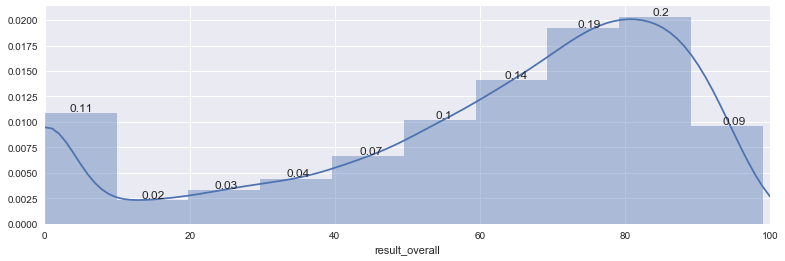

In [12]:
# 以10为区间
Interval_li = []
for i in range(11):
    middle = []
    middle.append('[' + str(i*10) + '-' + str((i+1)*10) + ']')
    value = eval('len(df_engine[(df_engine.result_overall>=' + str(i*10) + ') & (df_engine.result_overall<' +str((i+1)*10)+ ')])')
    middle.append(round(value/len(df_engine),2))
    Interval_li.append(middle)
    
    
sns.distplot(df_engine.result_overall,bins=10,norm_hist=True)
posi_li = [0.0111,0.0025,0.0035,0.0047,0.0068,0.0104,0.0143,0.0193,0.0205,0.0098]
plt.xlim(0,100)

m = 5
for i in range(10):
    plt.annotate(Interval_li[i][1], (m,posi_li[i]), horizontalalignment = 'center')
    m = m + 10

In [42]:
(overall_0, overall_not0)

(1269, 12088)

Text(0.5,1,u'overall grade distribution')

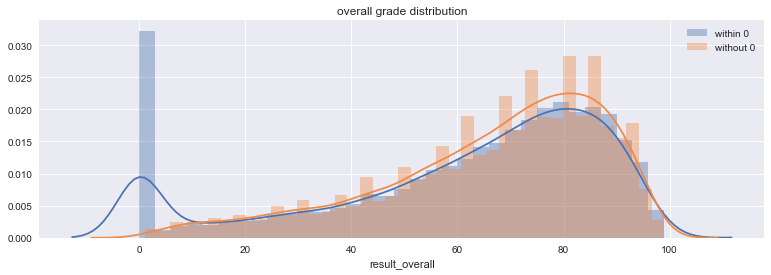

In [20]:
# without 0
plt.rc('figure', figsize=(13, 4))
sns.distplot(df_engine.result_overall, label='within 0')
sns.distplot(df_overall_not0.result_overall,color="#F08A47",label='without 0')
plt.legend(loc='best')
plt.title('overall grade distribution')

Text(0.5,1,u'overall grade distribution')

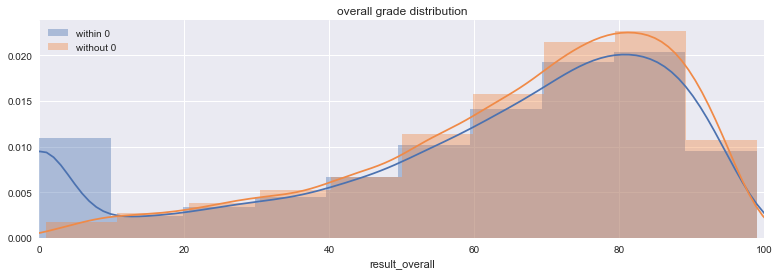

In [24]:
# 以10为区间
Interval_li = []
for i in range(11):
    middle = []
    middle.append('[' + str(i*10) + '-' + str((i+1)*10) + ']')
    value = eval('len(df_engine[(df_engine.result_overall>=' + str(i*10) + ') & (df_engine.result_overall<' +str((i+1)*10)+ ')])')
    middle.append(round(value/len(df_engine),2))
    Interval_li.append(middle)

Interval_li2 = []
for i in range(11):
    middle = []
    middle.append('[' + str(i*10) + '-' + str((i+1)*10) + ']')
    value = eval('len(df_overall_not0[(df_overall_not0.result_overall>=' + str(i*10) + ') & (df_overall_not0.result_overall<' +str((i+1)*10)+ ')])')
    middle.append(round(value/len(df_overall_not0),2))
    Interval_li2.append(middle)
    
    
sns.distplot(df_engine.result_overall,bins=10,norm_hist=True, label='within 0')
sns.distplot(df_overall_not0.result_overall,bins=10,norm_hist=True,color="#F08A47",label='without 0')
# posi_li = [0.0111,0.0025,0.0035,0.0047,0.0068,0.0104,0.0143,0.0193,0.0205,0.0098]
plt.xlim(0,100)
plt.legend(loc='best')
plt.title('overall grade distribution')

#m = 5
#for i in range(10):
#    plt.annotate(Interval_li[i][1], (m,posi_li[i]), horizontalalignment = 'center')
#    m = m + 10

### details分布

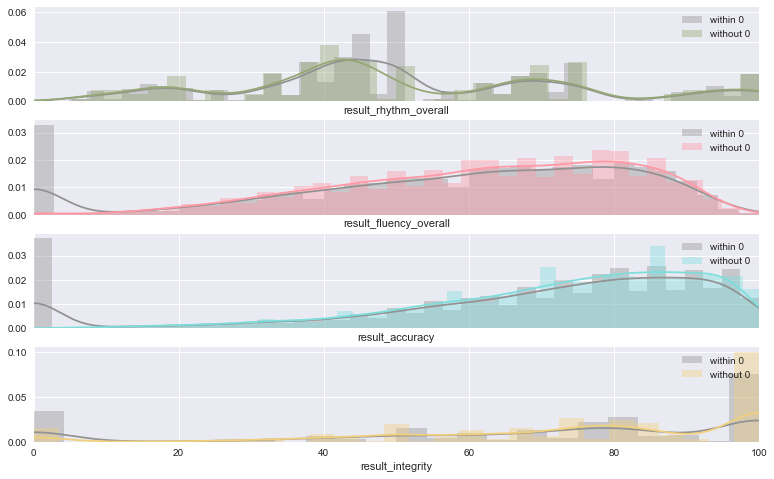

In [34]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 8), sharex=True)
plt.xlim(0, 100)

sns.distplot(df_engine.result_rhythm_overall,ax=ax1,color="#929292",label='within 0')
sns.distplot(df_overall_not0.result_rhythm_overall,ax=ax1, color="#95A773",label='without 0')

sns.distplot(df_engine.result_fluency_overall,ax=ax2,color="#929292",label='within 0')
sns.distplot(df_overall_not0.result_fluency_overall,ax=ax2, color="#FF98A4",label='without 0')

sns.distplot(df_engine.result_accuracy,ax=ax3,color="#929292",label='within 0')
sns.distplot(df_overall_not0.result_accuracy,ax=ax3, color="#7CDEDC",label='without 0')

sns.distplot(df_engine.result_integrity,ax=ax4,color="#929292",label='within 0')
sns.distplot(df_overall_not0.result_integrity,ax=ax4, color="#F2D07B",label='without 0')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

In [35]:
len(df_engine)

13357

Text(0.5,1,u'integrity')

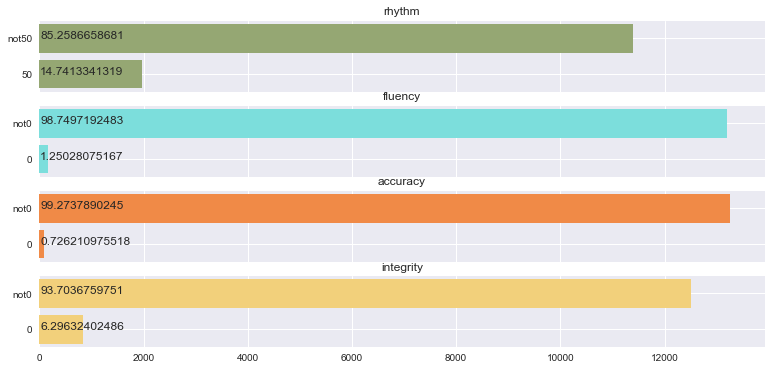

In [58]:
# 极值占比
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 6), sharex=True)

rhythm_li = []
rhythm_50 = df_engine.result_rhythm_overall.value_counts()[50]
rhythm_not50 = len(df_engine) - rhythm_50
rhythm_li.append(rhythm_not50)
rhythm_li.append(rhythm_50)
ax1.barh(['not50','50'],rhythm_li,facecolor="#95A773")
ax1.annotate(rhythm_50/len(df_engine)*100,xy=[13,0])
ax1.annotate(rhythm_not50/len(df_engine)*100,xy=[13,1])
ax1.set_title('rhythm')

fluency_li = []
fluency_0 = df_engine.result_fluency_overall.value_counts()[50]
fluency_not0 = len(df_engine) - fluency_0
fluency_li.append(fluency_not0)
fluency_li.append(fluency_0)
ax2.barh(['not0','0'],fluency_li,facecolor="#7CDEDC")
ax2.annotate(fluency_0/len(df_engine)*100,xy=[13,0])
ax2.annotate(fluency_not0/len(df_engine)*100,xy=[13,1])
ax2.set_title('fluency')

accuracy_li = []
accuracy_0 = df_engine.result_accuracy.value_counts()[50]
accuracy_not0 = len(df_engine) - accuracy_0
accuracy_li.append(accuracy_not0)
accuracy_li.append(accuracy_0)
ax3.barh(['not0','0'],accuracy_li,facecolor="#F08A47")
ax3.annotate(accuracy_0/len(df_engine)*100,xy=[13,0])
ax3.annotate(accuracy_not0/len(df_engine)*100,xy=[13,1])
ax3.set_title('accuracy')

integrity_li = []
integrity_0 = df_engine.result_integrity.value_counts()[50]
integrity_not0 = len(df_engine) - integrity_0
integrity_li.append(integrity_not0)
integrity_li.append(integrity_0)
ax4.barh(['not0','0'],integrity_li,facecolor="#F2D07B")
ax4.annotate(integrity_0/len(df_engine)*100,xy=[13,0])
ax4.annotate(integrity_not0/len(df_engine)*100,xy=[13,1])
ax4.set_title('integrity')

Text(13,1,u'85.2586658681')

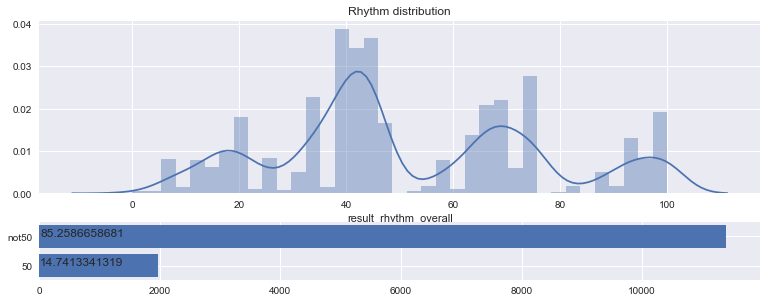

In [72]:
# 具体看rhythm的分布(去除rhythm=50记录)
rhythm_li = []
rhythm_50 = df_engine.result_rhythm_overall.value_counts()[50]
rhythm_not50 = len(df_engine) - rhythm_50
rhythm_li.append(rhythm_not50)
rhythm_li.append(rhythm_50)

rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_engine[df_engine.result_rhythm_overall != 50].result_rhythm_overall,ax=ax1)
ax1.set_title('Rhythm distribution')

ax2.barh(['not50','50'],rhythm_li)
ax2.annotate(rhythm_50/len(df_engine)*100,xy=[13,0])
ax2.annotate(rhythm_not50/len(df_engine)*100,xy=[13,1])
#ax2.set_title('Proportion of 0grade & not0grade')

Text(13,1,u'93.7036759751')

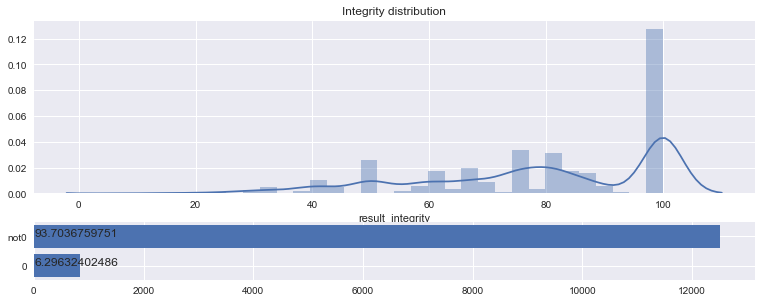

In [70]:
# 具体看integrity分布(去除integrity=0记录)
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_engine[df_engine.result_integrity != 0].result_integrity,ax=ax1)
ax1.set_title('Integrity distribution')

ax2.barh(['not0','0'],integrity_li)
ax2.annotate(integrity_0/len(df_engine)*100,xy=[13,0])
ax2.annotate(integrity_not0/len(df_engine)*100,xy=[13,1])

Text(13,1,u'99.2737890245')

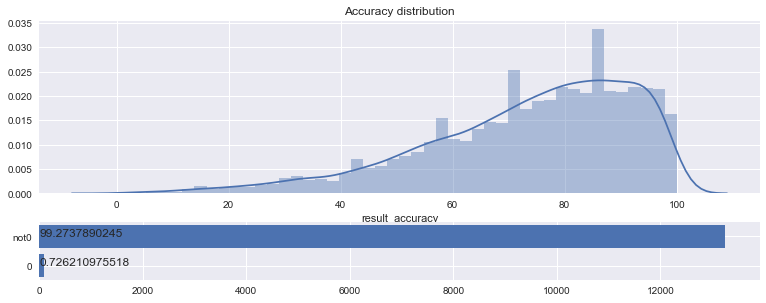

In [62]:
# 具体看accuracy分布（去除accuracy=0的记录）
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_engine[df_engine.result_accuracy != 0].result_accuracy,ax=ax1)
ax1.set_title('Accuracy distribution')

ax2.barh(['not0','0'],accuracy_li)
ax2.annotate(accuracy_0/len(df_engine)*100,xy=[13,0])
ax2.annotate(accuracy_not0/len(df_engine)*100,xy=[13,1])

Text(13,1,u'98.7497192483')

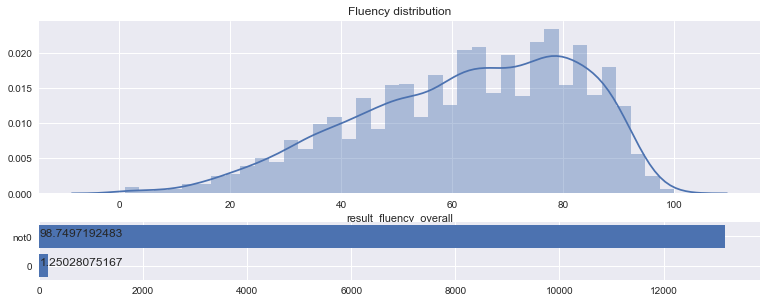

In [63]:
# 具体看fluency分布（去除fluency=0的记录）
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_engine[df_engine.result_fluency_overall != 0].result_fluency_overall,ax=ax1)
ax1.set_title('Fluency distribution')

ax2.barh(['not0','0'],fluency_li)
ax2.annotate(fluency_0/len(df_engine)*100,xy=[13,0])
ax2.annotate(fluency_not0/len(df_engine)*100,xy=[13,1])

### 特征与总分间的相关性

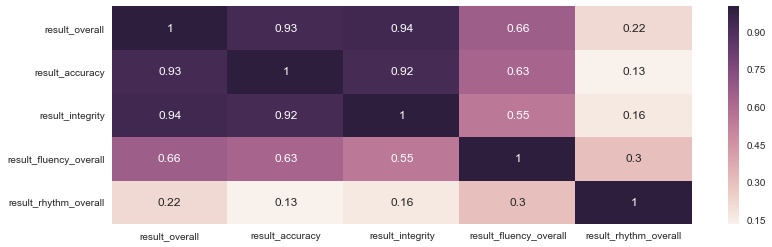

In [73]:
# 所有记录
from scipy.stats.stats import pearsonr

features = ['result_overall','result_accuracy','result_integrity','result_fluency_overall','result_rhythm_overall']
corr_li = []
for fea1 in features:
    middle_li = []
    for fea2 in features:
        middle_li.append(pearsonr(eval('df_engine.' + fea1 + '.values'), eval('df_engine.' + fea2 + '.values'))[0])
    corr_li.append(middle_li)
    
df_corr = DataFrame(corr_li)
df_corr.index = features
df_corr.columns = features

sns.heatmap(df_corr,annot=True)

In [628]:
df_corr2

,result_overall,result_info_snr,result_info_volume
result_overall,1.000000,0.205250,0.364988
result_info_snr,0.205250,1.000000,0.595096
result_info_volume,0.364988,0.595096,1.000000


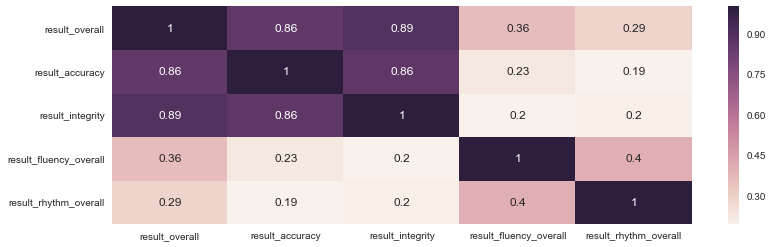

In [75]:
# 去除overall为0的记录后
features = ['result_overall','result_accuracy','result_integrity','result_fluency_overall','result_rhythm_overall']
corr_li2 = []
for fea1 in features:
    middle_li = []
    for fea2 in features:
        middle_li.append(pearsonr(eval('df_overall_not0.' + fea1 + '.values'), eval('df_overall_not0.' + fea2 + '.values'))[0])
    corr_li2.append(middle_li)
    
df_corr2 = DataFrame(corr_li2)
df_corr2.index = features
df_corr2.columns = features

sns.heatmap(df_corr2,annot=True)

In [320]:
from scipy.stats.stats import pearsonr

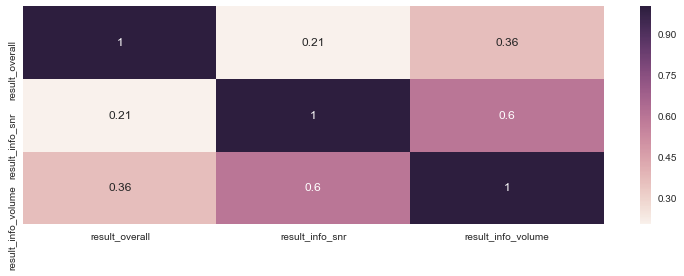

In [328]:
# 去除overall为0的记录后
features = ['result_overall','result_info_snr','result_info_volume']
corr_li2 = []
for fea1 in features:
    middle_li = []
    for fea2 in features:
        middle_li.append(pearsonr(eval('df_engine.' + fea1 + '.values'), eval('df_engine.' + fea2 + '.values'))[0])
    corr_li2.append(middle_li)
    
df_corr2 = DataFrame(corr_li2)
df_corr2.index = features
df_corr2.columns = features

sns.heatmap(df_corr2,annot=True)

### 可能影响评分的因素——信噪比snr

Text(0.5,1,u'signal noise ratio')

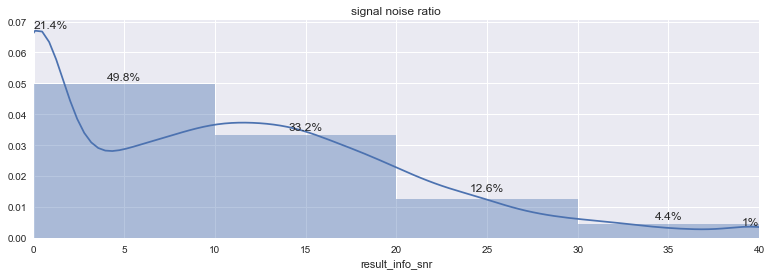

In [709]:
snr5 = len(df_engine[df_engine.result_info_snr < 10])/len(df_engine)
snr0 = len(df_engine[df_engine.result_info_snr == 0])/len(df_engine)
snr15 = len(df_engine[(df_engine.result_info_snr > 10)&(df_engine.result_info_snr <20)])/len(df_engine)
snr25 = len(df_engine[(df_engine.result_info_snr > 20)&(df_engine.result_info_snr <30)])/len(df_engine)
snr35 = len(df_engine[(df_engine.result_info_snr > 30)])/len(df_engine)
snr40 = len(df_engine[df_engine.result_info_snr == 40])/len(df_engine)

sns.distplot(df_engine.result_info_snr,bins=4)
plt.xlim(0,40)
plt.annotate('21.4%',[0,0.068],horizontalalignment = 'left')
plt.annotate('49.8%',[5,0.051],horizontalalignment = 'center')
plt.annotate('33.2%',[15,0.035],horizontalalignment = 'center')
plt.annotate('12.6%',[25,0.015],horizontalalignment = 'center')
plt.annotate('4.4%',[35,0.006],horizontalalignment = 'center')
plt.annotate('1%',[40,0.004],horizontalalignment = 'right')
plt.title('signal noise ratio')

(0, 40)

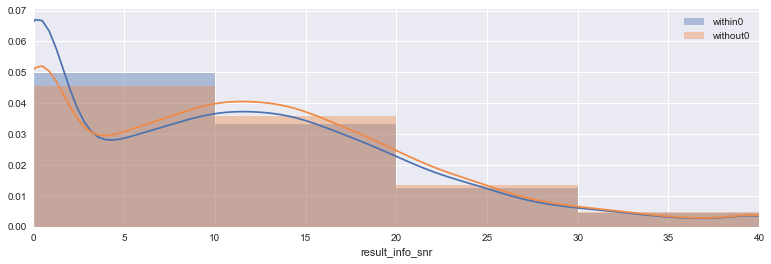

In [41]:
sns.distplot(df_engine.result_info_snr,bins=4, label='within0')
sns.distplot(df_overall_not0.result_info_snr, bins=4,color="#F08A47", label='without0' )
plt.legend(loc='best')
plt.xlim(0,40)

### 可能影响评分的因素——提示信息

In [710]:
df_engine.result_info_tipId.value_counts() / len(df_engine)

0.0        0.600734
10006.0    0.237329
10004.0    0.140675
10008.0    0.012353
10005.0    0.008909
Name: result_info_tipId, dtype: float64

Text(0.5,1,u'Tip information')

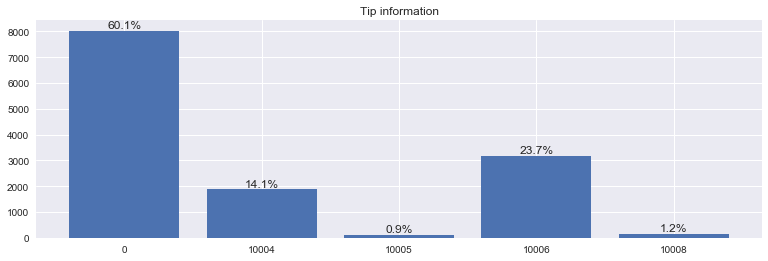

In [711]:
plt.bar(['0','10006','10004','10008','10005'],df_engine.result_info_tipId.value_counts().values)
plt.annotate('60.1%',[0,8124],horizontalalignment = 'center')
plt.annotate('23.7%',[10006,3270],horizontalalignment = 'center')
plt.annotate('14.1%',[10004,1979],horizontalalignment = 'center')
plt.annotate('1.2%',[10008,265],horizontalalignment = 'center')
plt.annotate('0.9%',[10005,219],horizontalalignment = 'center')
plt.title('Tip information')

In [718]:
len(df_engine)

13357

In [719]:
len(df_overall_not0)

12088

In [722]:
df_overall_not0.result_info_tipId.value_counts() / len(df_engine)

0.0        0.588231
10006.0    0.214045
10004.0    0.081680
10008.0    0.012203
10005.0    0.008834
Name: result_info_tipId, dtype: float64

Text(10005,300,u'0.9%')

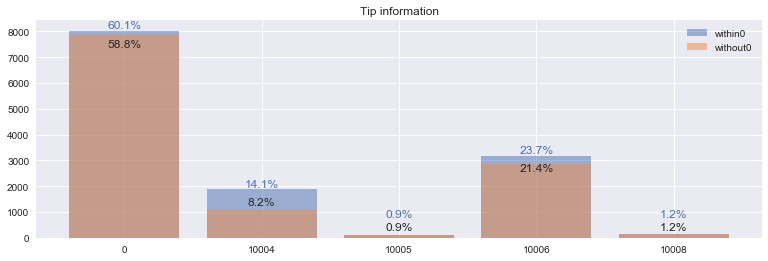

In [728]:
plt.bar(['0','10006','10004','10008','10005'],df_engine.result_info_tipId.value_counts().values, label='within0',alpha=0.5)
plt.bar(['0','10006','10004','10008','10005'],df_overall_not0.result_info_tipId.value_counts().values,color="#F08A47", label='without0',alpha=0.5)
plt.legend(loc='best')
plt.title('Tip information')
plt.annotate('60.1%',[0,8124],horizontalalignment = 'center',color=sns.color_palette()[0])
plt.annotate('23.7%',[10006,3270],horizontalalignment = 'center',color=sns.color_palette()[0])
plt.annotate('14.1%',[10004,1979],horizontalalignment = 'center',color=sns.color_palette()[0])
plt.annotate('1.2%',[10008,800],horizontalalignment = 'center',color=sns.color_palette()[0])
plt.annotate('0.9%',[10005,800],horizontalalignment = 'center',color=sns.color_palette()[0])

plt.annotate('58.8%',[0,7400],horizontalalignment = 'center')
plt.annotate('21.4%',[10006,2570],horizontalalignment = 'center')
plt.annotate('8.2%',[10004,1279],horizontalalignment = 'center')
plt.annotate('1.2%',[10008,300],horizontalalignment = 'center')
plt.annotate('0.9%',[10005,300],horizontalalignment = 'center')



In [49]:
df_overall_not0.result_info_tipId.value_counts()

0.0        7857
10006.0    2859
10004.0    1091
10008.0     163
10005.0     118
Name: result_info_tipId, dtype: int64

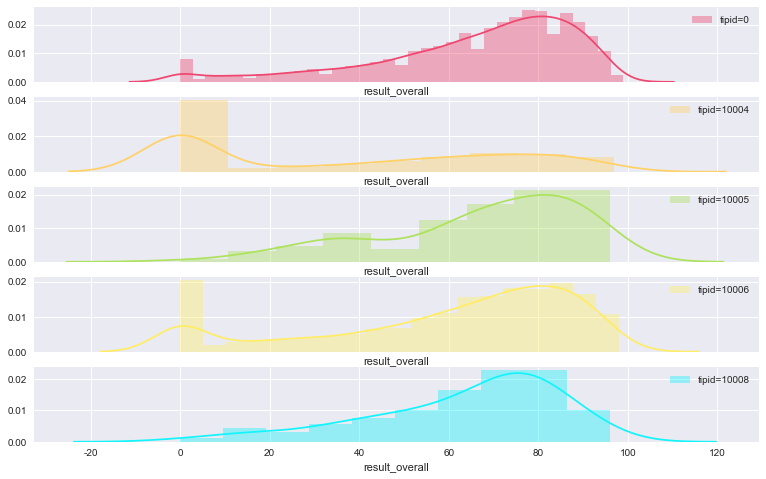

In [157]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(13, 8), sharex=True)
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall, ax=ax1, color="#EF476F",label='tipid=0')
sns.distplot(df_engine[df_engine.result_info_tipId == 10004].result_overall, ax=ax2, color="#FFD166",label='tipid=10004')
sns.distplot(df_engine[df_engine.result_info_tipId == 10005].result_overall, ax=ax3, color="#ADE25D",label='tipid=10005')
sns.distplot(df_engine[df_engine.result_info_tipId == 10006].result_overall, ax=ax4, color="#FFED66",label='tipid=10006')
sns.distplot(df_engine[df_engine.result_info_tipId == 10008].result_overall, ax=ax5, color="#14F4FC",label='tipid=10008')
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')
ax5.legend(loc='best')

### 可能影响评分的因素——音量大小

Text(0.5,1,u'Volume')

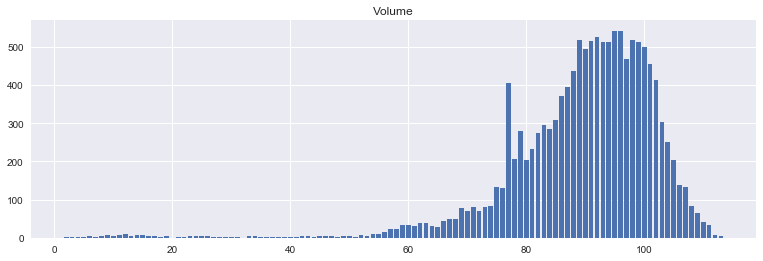

In [79]:
plt.bar(df_engine.result_info_volume.value_counts().index, df_engine.result_info_volume.value_counts().values)
plt.title('Volume')

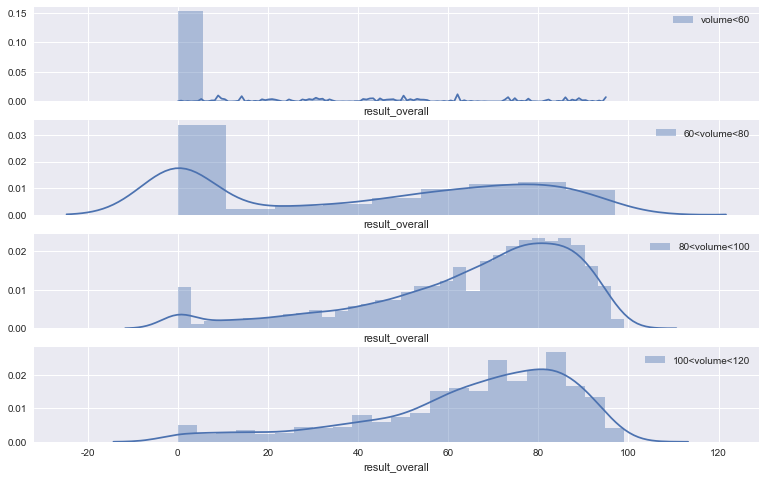

In [180]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 8), sharex=True)
sns.distplot(df_engine[df_engine.result_info_volume < 60].result_overall,ax=ax1,label='volume<60')
sns.distplot(df_engine[(df_engine.result_info_volume > 60) & (df_engine.result_info_volume < 80)].result_overall,ax=ax2,label='60<volume<80')
sns.distplot(df_engine[(df_engine.result_info_volume > 80) & (df_engine.result_info_volume < 100)].result_overall,ax=ax3,label='80<volume<100')
sns.distplot(df_engine[(df_engine.result_info_volume > 100) & (df_engine.result_info_volume < 120)].result_overall,ax=ax4,label='100<volume<120')
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')

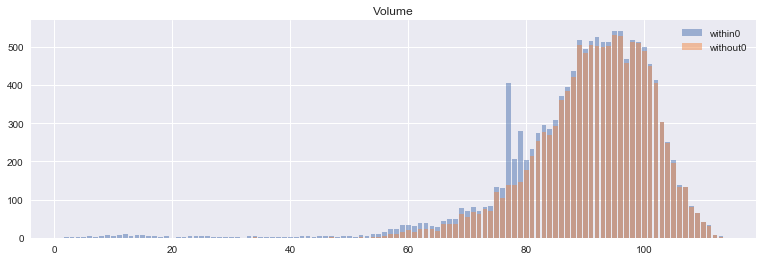

In [48]:
plt.bar(df_engine.result_info_volume.value_counts().index, df_engine.result_info_volume.value_counts().values, label='within0', alpha=0.5)
plt.bar(df_overall_not0.result_info_volume.value_counts().index, df_overall_not0.result_info_volume.value_counts().values,alpha=0.5,color="#F08A47", label='without0')
plt.title('Volume')
plt.legend(loc='best')

-----

### 为什么会有这么多0分

0分的记录（1269条）中大多数记录在accuracy，integrity，fluency，rhythm上的评分也为0，其中
* accuracy中，仅仅一条记录分值为3，其余分值皆为0
* integrity中，所有记录皆为0
* fluency中，0分值有1216条，其余53条记录分布于25—79之间，右偏态
* rhythm中，0分值有1221条，其余48条记录分布于8—100之间，正态

以此来看，各部分对总分的影响程度不同， integrity和accuracy相对严格，对最后总分的影响较大，而fluency和rhythm相对宽松

#### 查看各部分对最后总分影响占比

In [126]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

X = df_engine[['result_accuracy','result_integrity','result_fluency_overall','result_rhythm_overall']].values
y = df_engine.result_overall.values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.451e+05
Date:                Sun, 18 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:31:15   Log-Likelihood:                -46219.
No. Observations:               13357   AIC:                         9.245e+04
Df Residuals:                   13353   BIC:                         9.248e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2616      0.006     42.533      0.0

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [167]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

X = df_overall_not0[['result_accuracy','result_integrity','result_fluency_overall','result_rhythm_overall']].values
y = df_overall_not0.result_overall.values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.238e+05
Date:                Mon, 19 Mar 2018   Prob (F-statistic):               0.00
Time:                        10:03:36   Log-Likelihood:                -42378.
No. Observations:               12088   AIC:                         8.476e+04
Df Residuals:                   12084   BIC:                         8.479e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2546      0.006     39.328      0.0

integrity占比0.5，accuracy占比0.26，fluency占比0.14，rhythm占比0.02

In [185]:
#### 跟换占比，看overall
test_integrity = df_engine.result_integrity.values * 0.5 + df_engine.result_accuracy.values * 0.26 + df_engine.result_fluency_overall.values * 0.14 + df_engine.result_rhythm_overall.values * 0.1

In [186]:
test_integrity

array([ 52.28,  84.08,  85.26, ...,  66.9 ,   5.  ,  92.84])

Text(0.5,1,u'Distribution of overall grade')

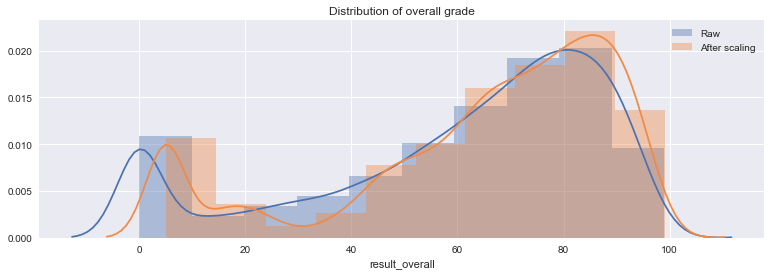

In [198]:
sns.distplot(df_engine.result_overall,bins=10, label='Raw')
sns.distplot(test_integrity, bins=10, label='After scaling', color="#F08A47",)
plt.legend(loc='best')
plt.title('Distribution of overall grade')

In [192]:
test = DataFrame(test_integrity)
test.columns = ['overall']

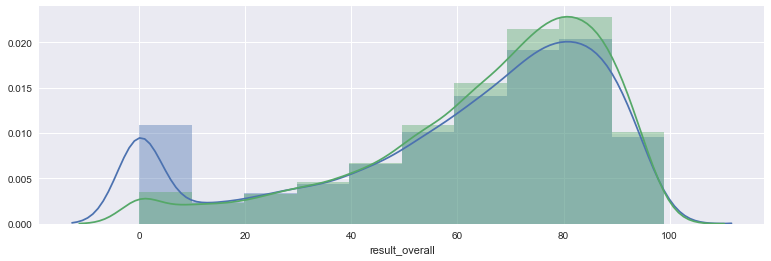

In [204]:
sns.distplot(df_engine.result_overall,bins=10)
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall, bins=10)

### 0分的记录

* 在评分细节上的分布

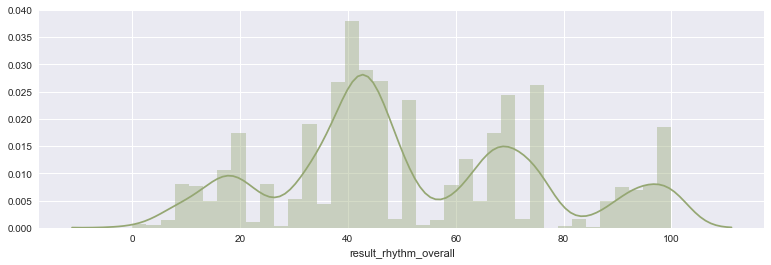

In [112]:
sns.distplot(df_overall_not0.result_rhythm_overall,color="#95A773")

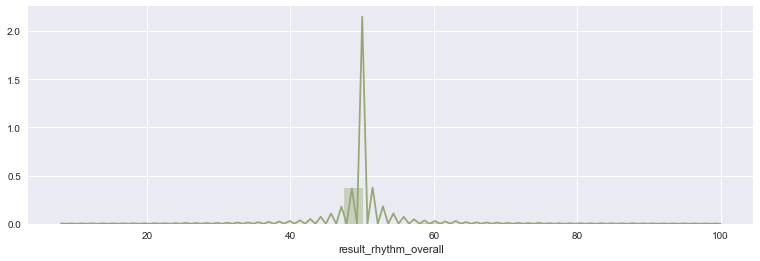

In [113]:
sns.distplot(df_overall_0.result_rhythm_overall,color="#95A773")

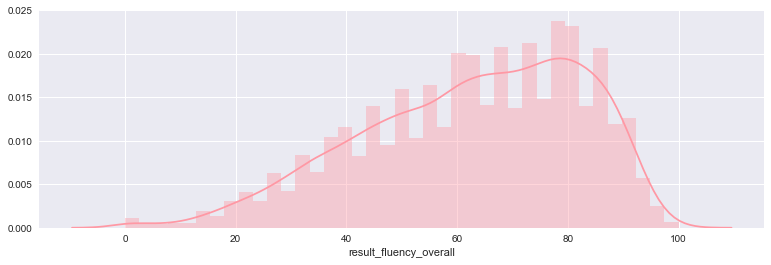

In [114]:
sns.distplot(df_overall_not0.result_fluency_overall,color="#FF98A4")

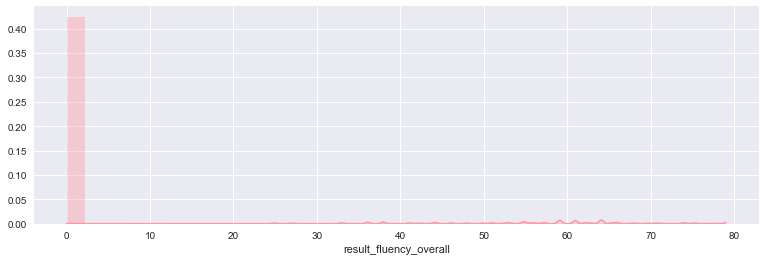

In [115]:
sns.distplot(df_overall_0.result_fluency_overall, color="#FF98A4")

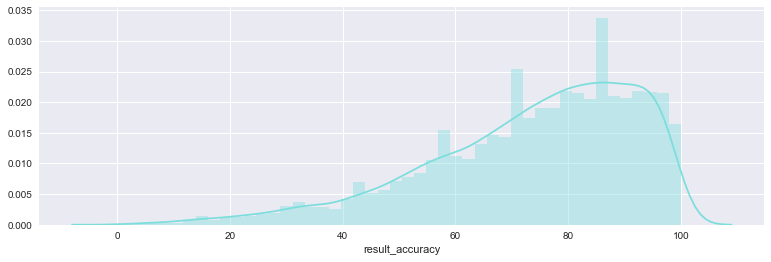

In [116]:
sns.distplot(df_overall_not0.result_accuracy,color="#7CDEDC")

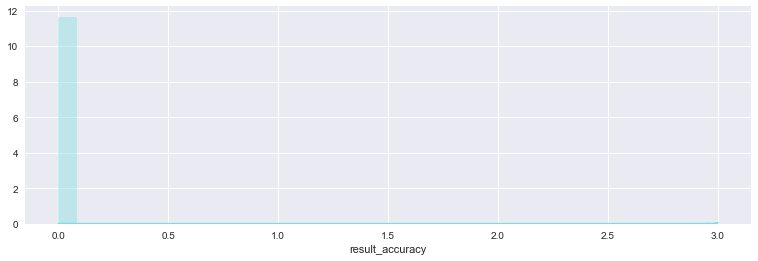

In [117]:
sns.distplot(df_overall_0.result_accuracy,color="#7CDEDC")

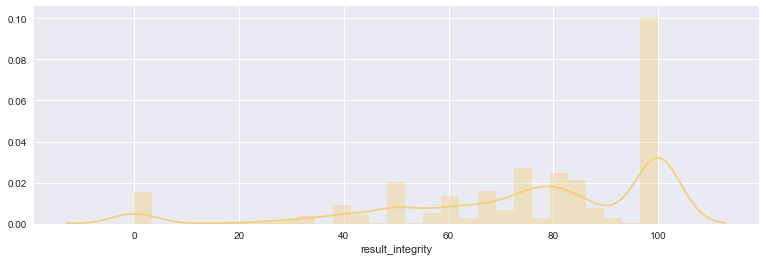

In [118]:
sns.distplot(df_overall_not0.result_integrity,color="#F2D07B")

(-0.06, 0.9)

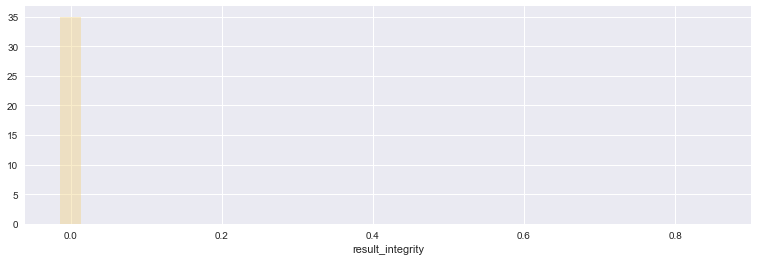

In [131]:
sns.distplot(df_overall_0.result_integrity,color="#F2D07B")
plt.xlim(-0.06,0.9)

* 在信噪比上的对比

In [735]:
df_engine_0_ratio = DataFrame()
df_engine_0_ratio['ratio'] = [len(df_overall_0) / len(df_engine), len(df_overall_not0) / len(df_engine)]
df_engine_0_ratio.index = ['0','not 0']

In [737]:
df_engine_0_ratio

,ratio
0,0.095006
not 0,0.904994


Text(0.55,0,u'90.5%')

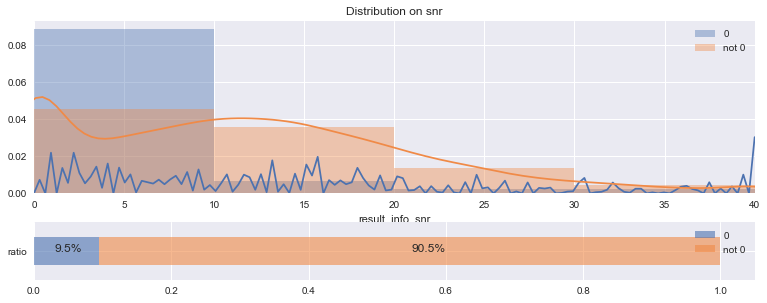

In [741]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_overall_0.result_info_snr,bins=4,label='0',ax=ax1)
sns.distplot(df_overall_not0.result_info_snr,bins=4,color="#F08A47",label='not 0',ax=ax1)
ax1.legend(loc='best')
ax1.set_xlim(0,40)
ax1.set_title('Distribution on snr')

df_engine_0_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=[sns.color_palette()[0],"#F08A47"], ax=ax2)
ax2.annotate('9.5%',[0.03,0])
ax2.annotate('90.5%',[0.55,0])

(0, 40)

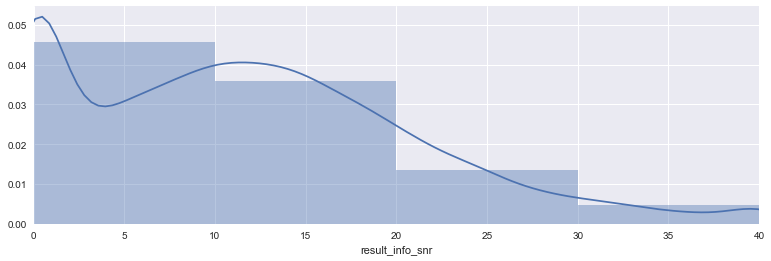

In [133]:
sns.distplot(df_overall_not0.result_info_snr,bins=4)
plt.xlim(0,40)

Text(0.55,0,u'90.5%')

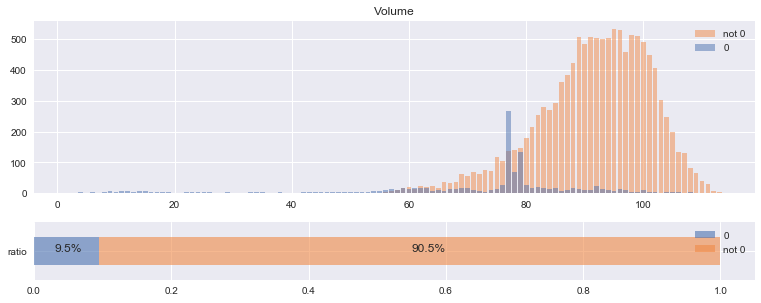

In [742]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

ax1.bar(df_overall_not0.result_info_volume.value_counts().index, 
        df_overall_not0.result_info_volume.value_counts().values,
        alpha=0.5,color="#F08A47", label='not 0')
ax1.bar(df_overall_0.result_info_volume.value_counts().index,
        df_overall_0.result_info_volume.value_counts().values, 
        label='0', alpha=0.5)
ax1.set_title('Volume')
ax1.legend(loc='best')

df_engine_0_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=[sns.color_palette()[0],"#F08A47"], ax=ax2)
ax2.annotate('9.5%',[0.03,0])
ax2.annotate('90.5%',[0.55,0])

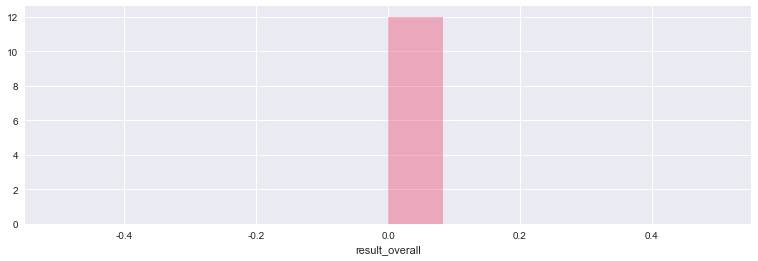

In [142]:
sns.distplot(df_overall_0[df_overall_0.result_info_tipId == 0].result_overall, color="#EF476F",label='tipid=0')

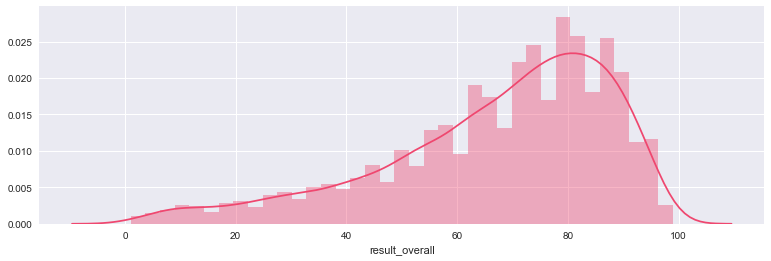

In [143]:
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 0].result_overall, color="#EF476F",label='tipid=0')

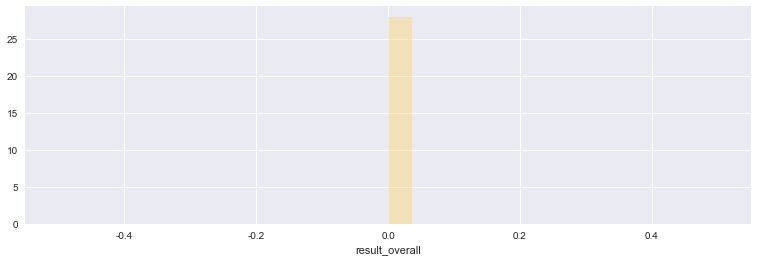

In [144]:
sns.distplot(df_overall_0[df_overall_0.result_info_tipId == 10004].result_overall, color="#FFD166",label='tipid=10004')

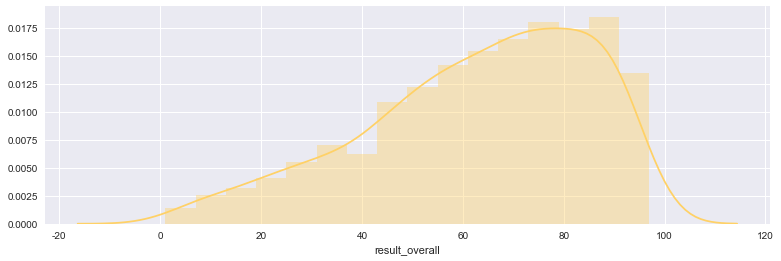

In [145]:
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10004].result_overall, color="#FFD166",label='tipid=10004')

TypeError: len() of unsized object

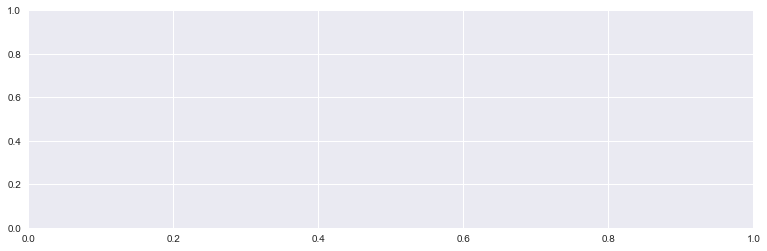

In [146]:
sns.distplot(df_overall_0[df_overall_0.result_info_tipId == 10005].result_overall, color="#ADE25D",label='tipid=10005')

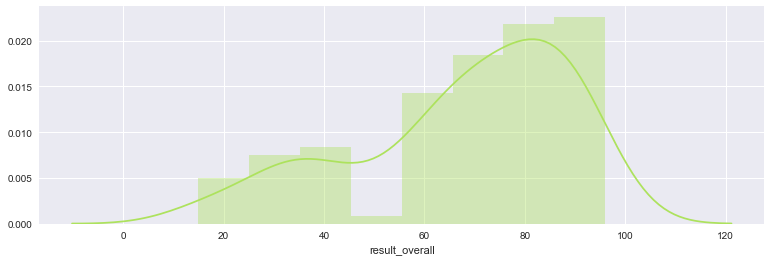

In [147]:
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10005].result_overall, color="#ADE25D",label='tipid=10005')

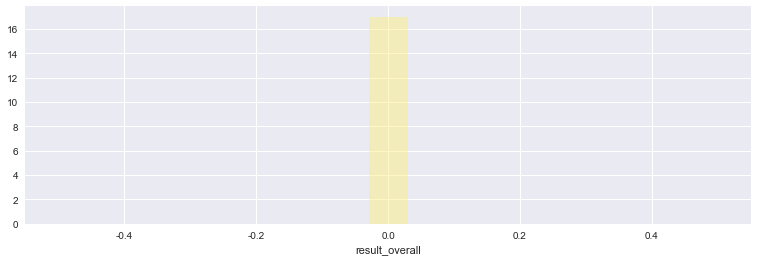

In [148]:
sns.distplot(df_overall_0[df_overall_0.result_info_tipId == 10006].result_overall, color="#FFED66",label='tipid=10006')

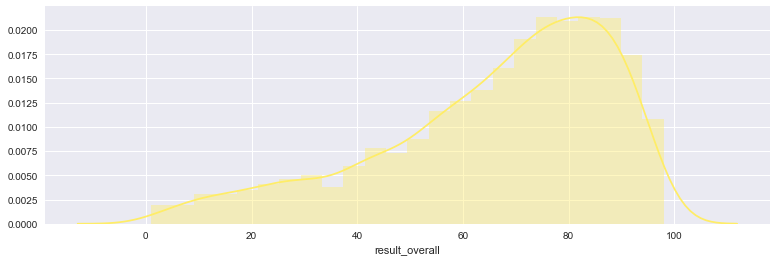

In [149]:
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10006].result_overall, color="#FFED66",label='tipid=10006')

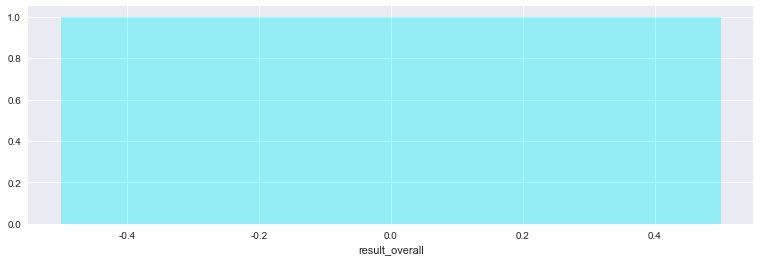

In [150]:
sns.distplot(df_overall_0[df_overall_0.result_info_tipId == 10008].result_overall, color="#14F4FC",label='tipid=10008')

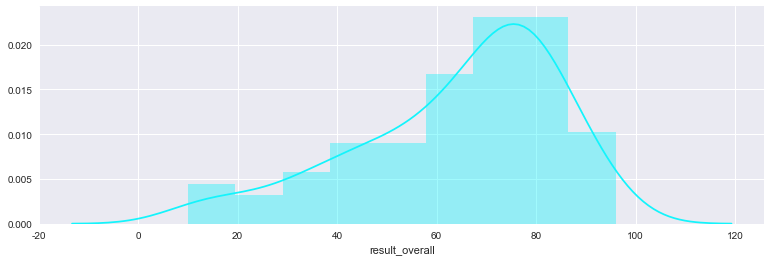

In [151]:
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10008].result_overall, color="#14F4FC",label='tipid=10008')

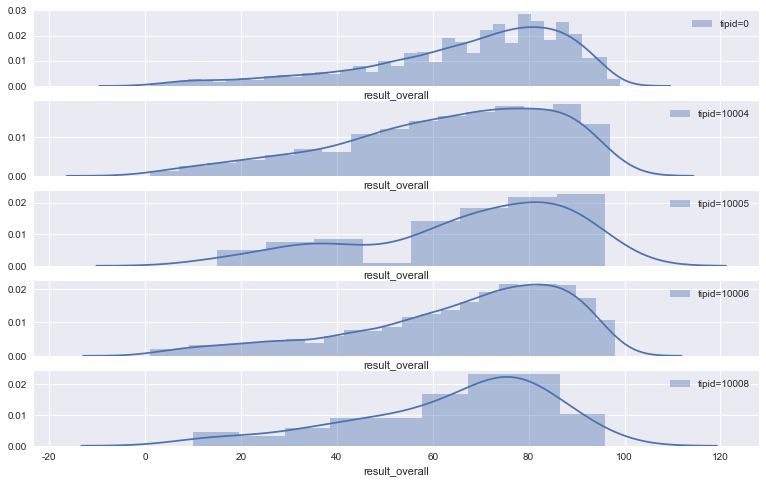

In [707]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(13, 8), sharex=True)
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 0].result_overall, ax=ax1,label='tipid=0')
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10004].result_overall, ax=ax2,label='tipid=10004')
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10005].result_overall, ax=ax3,label='tipid=10005')
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10006].result_overall, ax=ax4,label='tipid=10006')
sns.distplot(df_overall_not0[df_overall_not0.result_info_tipId == 10008].result_overall, ax=ax5,label='tipid=10008')
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')
ax5.legend(loc='best')

In [159]:
df_overall_0.result_info_tipId.value_counts()

10004.0    788
10006.0    311
0.0        167
10008.0      2
10005.0      1
Name: result_info_tipId, dtype: int64

In [157]:
df_overall_not0.result_info_tipId.value_counts()

0.0        7857
10006.0    2859
10004.0    1091
10008.0     163
10005.0     118
Name: result_info_tipId, dtype: int64

In [161]:
li_0 = []
li_not0 = []
labels = [0,10004,10005,10006,10008]
for label in labels:
    li_0.append(round(df_overall_0.result_info_tipId.value_counts()[label]/len(df_overall_0),2))
    li_not0.append(round(df_overall_not0.result_info_tipId.value_counts()[label] / len(df_overall_not0),2))

Text(0.5,1,u'ratio of each tips')

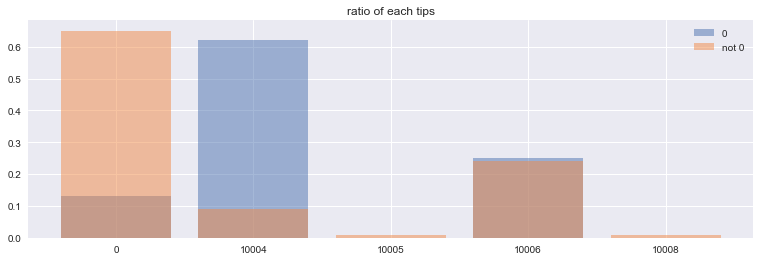

In [170]:
plt.bar(['0','10004','10005','10006','10008'] ,li_0, alpha=0.5,label='0')
plt.bar(['0','10004','10005','10006','10008'] ,li_not0, alpha=0.5,color="#F08A47",label='not 0')
plt.legend(loc='best')
plt.title('ratio of each tips')
plt

In [350]:
li_0 = [0.0125, 0.059, 0.0001, 0.0233, 0.0001]
li_not0 = [0.5882, 0.0817, 0.0088, 0.214, 0.0122]
df_li = DataFrame()
df_li['0'] = li_0
df_li['not0'] = li_not0

In [351]:
df_li.index = [0,10004,10005,10006,10008]

In [744]:
df_li

,0,not0
0,0.0125,0.5882
10004,0.0590,0.0817
10005,0.0001,0.0088
10006,0.0233,0.2140
10008,0.0001,0.0122


Text(0.55,0,u'90.5%')

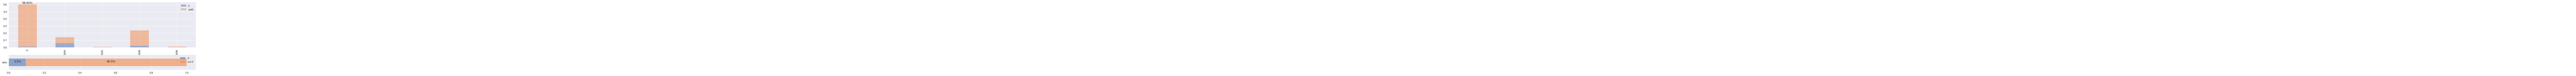

In [747]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

df_li.plot(kind='bar',stacked=True,color=[sns.color_palette()[0], "#F08A47"], alpha=0.5,ax=ax1)
ax1.annotate('58.82%', (0,0.61), horizontalalignment = 'center')
ax1.annotate('8.17%', (10004,0.15), horizontalalignment = 'center')
ax1.annotate('0.88%', (10005,0.015), horizontalalignment = 'center')
ax1.annotate('21.4%', (10006,0.246), horizontalalignment = 'center')
ax1.annotate('1.22%', (10008,0.02), horizontalalignment = 'center')

#plt.annotate('1.25%',[0,0],horizontalalignment = 'center',color=sns.color_palette()[0])
#plt.annotate('5.9%',[10004,0],horizontalalignment = 'center',color=sns.color_palette()[0])
#plt.annotate('0.01%',[10005,0],horizontalalignment = 'center',color=sns.color_palette()[0])
#plt.annotate('2.33%',[10006,0],horizontalalignment = 'center',color=sns.color_palette()[0])
#plt.annotate('0.01%',[10008,0],horizontalalignment = 'center',color=sns.color_palette()[0])

df_engine_0_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=[sns.color_palette()[0],"#F08A47"], ax=ax2)
ax2.annotate('9.5%',[0.03,0])
ax2.annotate('90.5%',[0.55,0])

In [337]:
df_li

,0,not0
0,0.13,0.65
10004,0.62,0.09
10005,0.00,0.01
10006,0.25,0.24
10008,0.00,0.01


# 具体分析

0 or not0 / tipId | 0 | 10004 | 10005 | 10006 | 10008 
- | --- | --- | --- | -
得分为0的记录 | 13% | 62% | 0% | 25% | 0% 
得分非0的记录 | 65% | 9% | 1% | 24% | 1%  

In [218]:
df_overall_0_tip0 = df_overall_0[df_overall_0.result_info_tipId==0]
df_overall_0_tip4 = df_overall_0[df_overall_0.result_info_tipId==10004]
df_overall_0_tip5 = df_overall_0[df_overall_0.result_info_tipId==10005]
df_overall_0_tip6 = df_overall_0[df_overall_0.result_info_tipId==10006]
df_overall_0_tip8 = df_overall_0[df_overall_0.result_info_tipId==10008]

df_overall_not0_tip0 = df_overall_not0[df_overall_not0.result_info_tipId==0]
df_overall_not0_tip4 = df_overall_not0[df_overall_not0.result_info_tipId==10004]
df_overall_not0_tip5 = df_overall_not0[df_overall_not0.result_info_tipId==10005]
df_overall_not0_tip6 = df_overall_not0[df_overall_not0.result_info_tipId==10006]
df_overall_not0_tip8 = df_overall_not0[df_overall_not0.result_info_tipId==10008]

In [220]:
(len(df_overall_0), len(df_overall_not0))

(1269, 12088)

In [222]:
len(df_overall_0_tip0) + len(df_overall_0_tip4) + len(df_overall_0_tip5) + len(df_overall_0_tip6) + len(df_overall_0_tip8) 

1269

In [223]:
len(df_overall_not0_tip0) + len(df_overall_not0_tip4) + len(df_overall_not0_tip5) + len(df_overall_not0_tip6) + len(df_overall_not0_tip8) 

12088

In [235]:
(round(len(df_overall_0_tip0) / len(df_engine), 4),
round(len(df_overall_0_tip4) / len(df_engine), 4),
round(len(df_overall_0_tip5) / len(df_engine), 4),
round(len(df_overall_0_tip6) / len(df_engine), 4),
round(len(df_overall_0_tip8) / len(df_engine), 4),
)

(0.0125, 0.059, 0.0001, 0.0233, 0.0001)

In [236]:
(round(len(df_overall_not0_tip0) / len(df_engine), 4),
round(len(df_overall_not0_tip4) / len(df_engine), 4),
round(len(df_overall_not0_tip5) / len(df_engine), 4),
round(len(df_overall_not0_tip6) / len(df_engine), 4),
round(len(df_overall_not0_tip8) / len(df_engine), 4),
)

(0.5882, 0.0817, 0.0088, 0.214, 0.0122)

0 or not0 / tipId | 0 | 10004 | 10005 | 10006 | 10008 
- | --- | --- | --- | -
得分为0的记录 | 1.25% | 5.9% | 0.01% | 2.33% | 0.01% 
得分非0的记录 | 58.82% | 8.17% | 0.88% | 21.4% | 1.22%  

In [242]:
(round(len(df_overall_0_tip0) / 8024, 4),
round(len(df_overall_0_tip4) / 1879, 4),
round(len(df_overall_0_tip5) / 119, 4),
round(len(df_overall_0_tip6) / 3170, 4),
round(len(df_overall_0_tip8) / 165, 4),
)

(0.0208, 0.4194, 0.0084, 0.0981, 0.0121)

In [241]:
(round(len(df_overall_not0_tip0) / 8024, 4),
round(len(df_overall_not0_tip4) / 1879, 4),
round(len(df_overall_not0_tip5) / 119, 4),
round(len(df_overall_not0_tip6) / 3170, 4),
round(len(df_overall_not0_tip8) / 165, 4),
)

(0.9792, 0.5806, 0.9916, 0.9019, 0.9879)

0 or not0 / tipId | 0 | 10004 | 10005 | 10006 | 10008 
- | --- | --- | --- | -
得分为0的记录 | 2.08% | 41.94% | 0.84% | 9.81% | 1.21% 
得分非0的记录 | 97.92% | 58.06% | 99.16% | 90.19% | 98.79%  

(0, 40)

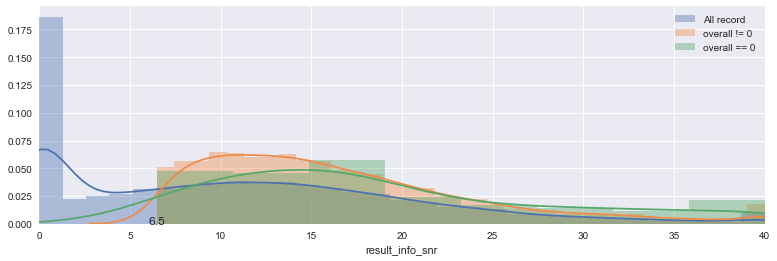

In [247]:
sns.distplot(df_engine.result_info_snr, label='All record')
sns.distplot(df_overall_not0_tip0.result_info_snr,color="#F08A47", label='overall != 0')
sns.distplot(df_overall_0_tip0.result_info_snr, label='overall == 0')
# sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_info_snr)
plt.legend(loc='best')
plt.annotate(6.5, (6.5, 0), horizontalalignment = 'center')
plt.title('snr distribution')
plt.xlim(0,40)

In [202]:
(df_overall_0_tip0.result_info_snr.min(), df_overall_not0_tip0.result_info_snr.min())

(6.5046870000000006, 6.5011019999999995)

In [301]:
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_info_snr, label='tip = 0')
sns.distplot(df_engine[df_engine.result_info_tipId == 10006].result_info_snr, label='tip = 10006')
sns.distplot(df_engine[df_engine.result_info_tipId == 10008].result_info_snr, label='tip = 10008')
plt.axvline(6.5, color='red', linestyle='dashed')
plt.axvline(7, color='blue', linestyle='dashed')
plt.annotate(6.5, (6.5,0.5), horizontalalignment = 'left',color='red')
plt.annotate(7, (7,0.4), horizontalalignment = 'left',color='bule')
plt.xlim(0,40)
plt.title('snr distribution')
plt.legend(loc='best')

ValueError: Invalid RGBA argument: 'bule'

In [296]:
(df_engine[df_engine.result_info_tipId == 10004].result_info_snr.min(),
df_engine[df_engine.result_info_tipId == 10004].result_info_snr.max(),)

(0.0, 40.0)

In [297]:
(df_engine[df_engine.result_info_tipId == 10005].result_info_snr.min(),
df_engine[df_engine.result_info_tipId == 10005].result_info_snr.max(),)

(0.0, 40.0)

In [298]:
(df_engine[df_engine.result_info_tipId == 10008].result_info_snr.min(),
df_engine[df_engine.result_info_tipId == 10008].result_info_snr.max(),)

(6.9821309999999999, 40.0)

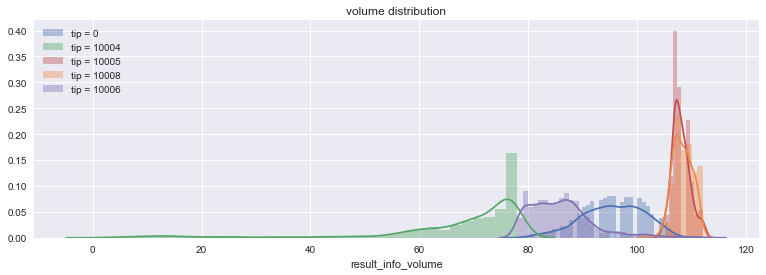

In [282]:
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_info_volume, label='tip = 0')
sns.distplot(df_engine[df_engine.result_info_tipId == 10004].result_info_volume, label='tip = 10004')
sns.distplot(df_engine[df_engine.result_info_tipId == 10005].result_info_volume, label='tip = 10005')
sns.distplot(df_engine[df_engine.result_info_tipId == 10008].result_info_volume, label='tip = 10008', color="#F08A47")
sns.distplot(df_engine[df_engine.result_info_tipId == 10006].result_info_volume, label='tip = 10006')
# plt.annotate(6.5, (6.5,0), horizontalalignment = 'center')
plt.title('volume distribution')
plt.legend(loc='best')

In [270]:
(df_engine[df_engine.result_info_tipId == 0].result_info_volume.min(), df_engine[df_engine.result_info_tipId == 0].result_info_volume.max())

(78.0, 111.0)

In [271]:
df_engine[df_engine.result_info_tipId == 10004].result_info_volume.max()

78.0

In [278]:
(df_engine[df_engine.result_info_tipId == 10005].result_info_volume.min(), df_engine[df_engine.result_info_tipId == 10005].result_info_volume.max())

(105.0, 112.0)

In [279]:
(df_engine[df_engine.result_info_tipId == 10008].result_info_volume.min(), df_engine[df_engine.result_info_tipId == 10008].result_info_volume.max())

(102.0, 112.0)

In [281]:
(df_engine[df_engine.result_info_tipId == 10006].result_info_volume.min(), df_engine[df_engine.result_info_tipId == 10006].result_info_volume.max())

(78.0, 113.0)

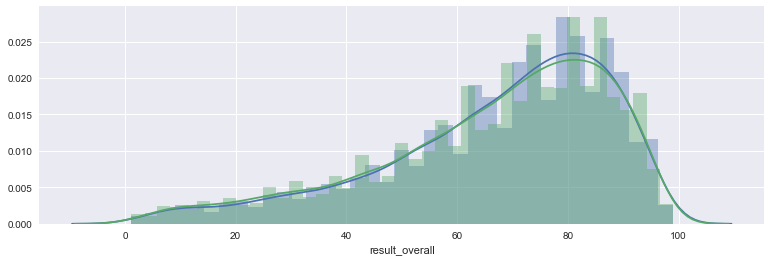

In [305]:
sns.distplot(df_overall_not0_tip0.result_overall)
sns.distplot(df_overall_not0.result_overall)

# 为什么有0分

什么因素造成有那么多0分？

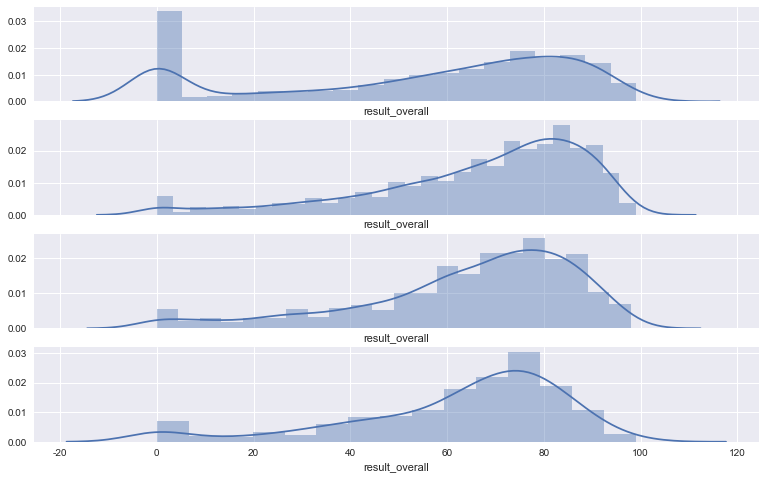

In [379]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 8), sharex=True)
sns.distplot(df_engine[df_engine.result_info_snr <10].result_overall,ax=ax1)
sns.distplot(df_engine[(df_engine.result_info_snr >10) & (df_engine.result_info_snr < 20)].result_overall,ax=ax2)
sns.distplot(df_engine[(df_engine.result_info_snr >20) & (df_engine.result_info_snr < 30)].result_overall,ax=ax3)
sns.distplot(df_engine[(df_engine.result_info_snr >30) & (df_engine.result_info_snr < 40)].result_overall,ax=ax4)

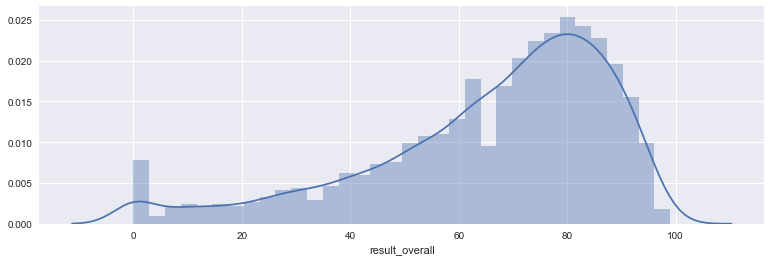

In [378]:
sns.distplot(df_engine[df_engine.result_info_snr >10].result_overall)

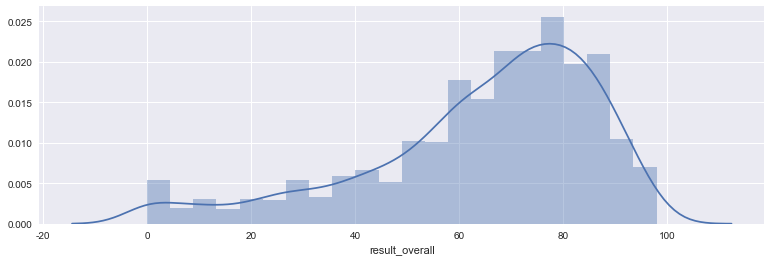

In [376]:
sns.distplot(df_engine[(df_engine.result_info_snr >20) & (df_engine.result_info_snr < 30)].result_overall)

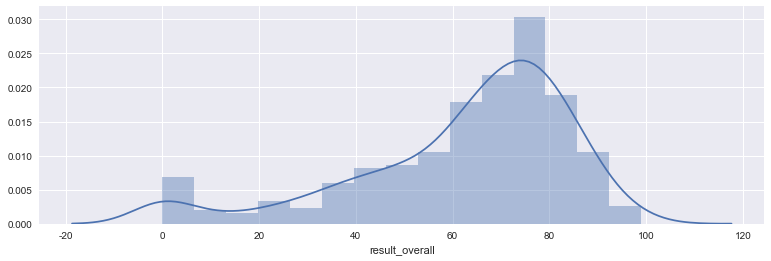

In [377]:
sns.distplot(df_engine[(df_engine.result_info_snr >30) & (df_engine.result_info_snr < 40)].result_overall)

# 怎么区分质量不好

质量不好： tipid !=0 ?  /  overall == 0 ？

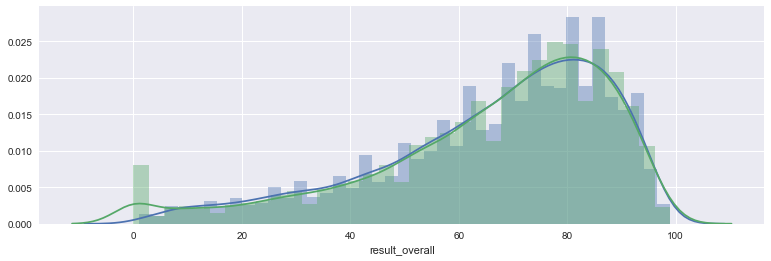

In [393]:
sns.distplot(df_overall_not0.result_overall)
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall)

In [400]:
df_engine[df_engine.result_info_tipId != 0]

,refText,result_accuracy,result_fluency_overall,result_fluency_pause,result_fluency_speed,result_info_snr,result_info_tipId,result_info_volume,result_integrity,result_overall,result_rhythm_overall,result_rhythm_sense,result_rhythm_stress,result_rhythm_tone,result_wavetime
8,Don't eat in the classroom. You must eat in th...,63.0,74.0,1.0,1.0,2.301756,10006.0,91.0,69.0,56.0,21.0,0.0,83.0,0.0,6130.0
10,I've got more cakes than you have.,54.0,66.0,2.0,0.0,0.000000,10006.0,81.0,50.0,46.0,43.0,0.0,71.0,100.0,3390.0
11,This is the best cake I've ever had.,72.0,82.0,0.0,2.0,0.000000,10006.0,81.0,56.0,58.0,72.0,100.0,88.0,0.0,2860.0
12,There are fewer girls than boys.,0.0,0.0,0.0,1.0,0.000000,10004.0,77.0,0.0,0.0,50.0,100.0,0.0,0.0,3010.0
14,It was colder yesterday.,0.0,0.0,0.0,1.0,0.000000,10006.0,83.0,0.0,0.0,50.0,100.0,0.0,0.0,2290.0
15,It was colder yesterday.,51.0,76.0,0.0,2.0,25.440878,10005.0,108.0,40.0,45.0,63.0,100.0,50.0,0.0,2670.0
17,"""This is my mother and father, Mrs. Star and M...",95.0,73.0,0.0,1.0,2.564451,10006.0,87.0,67.0,62.0,11.0,0.0,45.0,0.0,3920.0
28,I like eating carrots.,96.0,74.0,1.0,0.0,4.069895,10006.0,86.0,100.0,91.0,19.0,0.0,75.0,0.0,3290.0
29,What's that in English?,66.0,67.0,0.0,0.0,2.217705,10006.0,88.0,60.0,71.0,38.0,0.0,50.0,100.0,2620.0
31,But I have to go to bed before ten o'clock.,91.0,84.0,0.0,1.0,6.108483,10006.0,89.0,91.0,86.0,73.0,50.0,90.0,100.0,4530.0


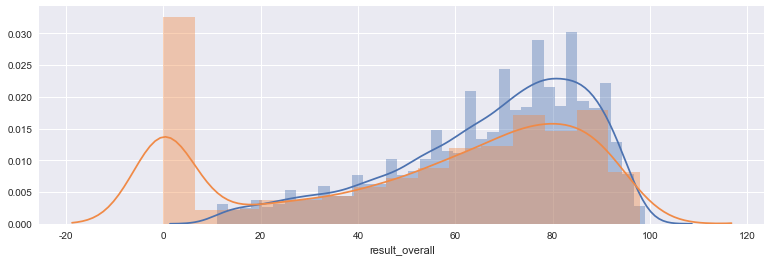

In [423]:
sns.distplot(df_engine[df_engine.result_overall > 10].result_overall)
sns.distplot(df_engine[df_engine.result_info_tipId != 0].result_overall,color="#F08A47")

In [ ]:
df_engine[df_engine.result_info_tipId]

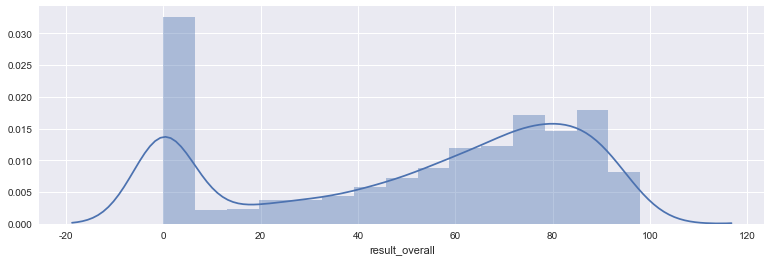

In [420]:
sns.distplot(df_engine[df_engine.result_info_tipId != 0].result_overall)

# 质量好的是否准确了

overall

rhythm，accuracy, integrity, fluency

snr, volume, tipid

In [308]:
test = df_engine.values

In [426]:
df_engine[df_engine.result_fluency_overall == 0].result_integrity.value_counts()

0.0      1217
100.0      10
75.0        5
60.0        1
Name: result_integrity, dtype: int64

In [428]:
len(df_engine[df_engine.result_integrity == 0])

1910

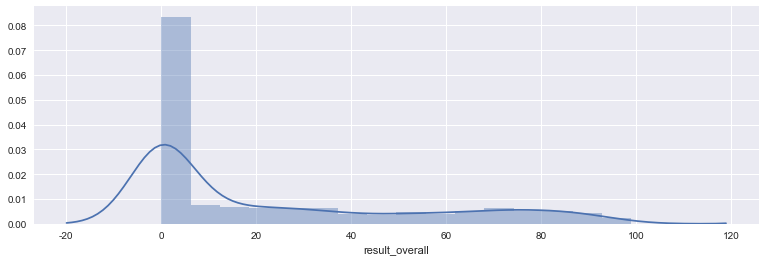

In [436]:
sns.distplot(df_engine[(df_engine.result_accuracy == 0) | (df_engine.result_integrity == 0) 
          | (df_engine.result_rhythm_overall == 50) | (df_engine.result_fluency_overall == 0)].result_overall)

In [494]:
df_bad = df_engine[(df_engine.result_accuracy == 0) | (df_engine.result_integrity == 0) 
          | (df_engine.result_fluency_overall == 0)]

In [462]:
sns.distplot(df_good.result_overall,label='after selected',bins=10)


0.19564240790655885

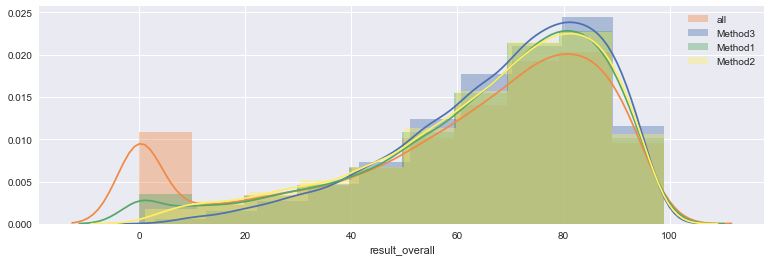

In [510]:
sns.distplot(df_engine.result_overall,label='all',color="#F08A47",bins=10)
sns.distplot(df_good.result_overall,label='Method3',bins=10)
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall,bins=10,label='Method1')
sns.distplot(df_overall_not0.result_overall,bins=10,color="#FFED66",label='Method2')
plt.legend(loc='best')

In [496]:
index_li = df_bad.index
df_good = test.drop(index_li)

In [492]:
df_bad[['result_overall','result_integrity','result_accuracy','result_rhythm_overall','result_fluency_overall']]

,result_overall,result_integrity,result_accuracy,result_rhythm_overall,result_fluency_overall
12,0.0,0.0,0.0,50.0,0.0
14,0.0,0.0,0.0,50.0,0.0
42,0.0,0.0,0.0,50.0,0.0
43,0.0,0.0,0.0,50.0,0.0
44,0.0,0.0,0.0,50.0,0.0
45,0.0,0.0,0.0,50.0,0.0
46,0.0,0.0,0.0,50.0,0.0
47,0.0,0.0,0.0,50.0,0.0
48,0.0,0.0,0.0,50.0,0.0
49,0.0,0.0,0.0,50.0,0.0


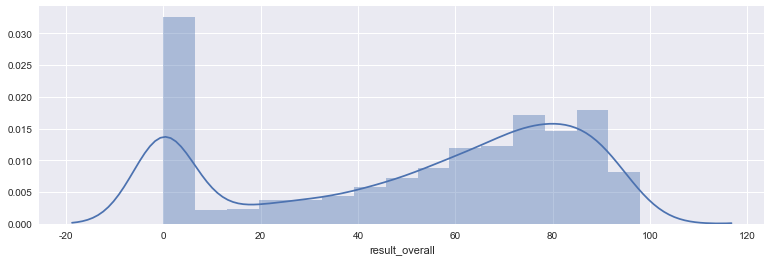

In [450]:
sns.distplot(df_engine[df_engine.result_info_tipId != 0].result_overall)

In [499]:
df_good.resu

refText                   """Go home,"" the doctor says to the robot."
result_accuracy                                                     19
result_fluency_overall                                               1
result_fluency_pause                                                 0
result_fluency_speed                                                 0
result_info_snr                                                      0
result_info_tipId                                                    0
result_info_volume                                                  34
result_integrity                                                     8
result_overall                                                       3
result_rhythm_overall                                                0
result_rhythm_sense                                                  0
result_rhythm_stress                                                 0
result_rhythm_tone                                                   0
result

In [488]:
df_overall_0.result_accuracy.value_counts()

0.0    1268
3.0       1
Name: result_accuracy, dtype: int64

In [489]:
df_overall_0.result_integrity.value_counts()

0.0    1269
Name: result_integrity, dtype: int64

In [490]:
df_overall_0.result_rhythm_overall.value_counts()

50.0     1221
58.0        9
63.0        6
75.0        3
25.0        3
42.0        3
56.0        2
33.0        2
88.0        2
67.0        2
83.0        2
44.0        2
60.0        1
100.0       1
61.0        1
80.0        1
55.0        1
54.0        1
38.0        1
52.0        1
8.0         1
29.0        1
53.0        1
69.0        1
Name: result_rhythm_overall, dtype: int64

In [511]:
len(df_bad)

1926

In [514]:
len(df_good)

11431

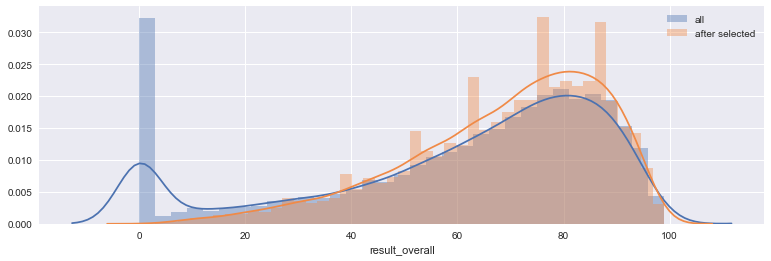

In [535]:
sns.distplot(df_engine.result_overall,label='all')
sns.distplot(df_good.result_overall,label='after selected', color="#F08A47")
plt.legend(loc='best')

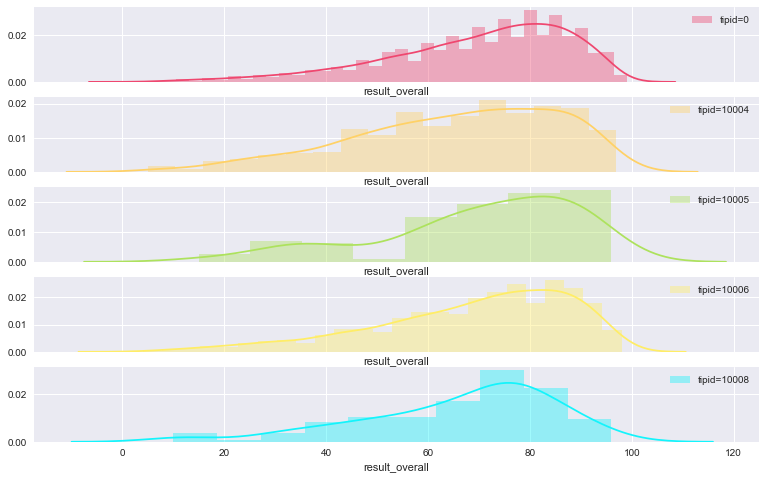

In [533]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(13, 8), sharex=True)
#sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall,ax=ax1,color="#929292",label='all')
sns.distplot(df_good[df_good.result_info_tipId == 0].result_overall, ax=ax1, color="#EF476F",label='tipid=0')
#sns.distplot(df_engine[df_engine.result_info_tipId == 10004].result_overall,ax=ax2,color="#929292",label='all')
sns.distplot(df_good[df_good.result_info_tipId == 10004].result_overall, ax=ax2, color="#FFD166",label='tipid=10004')
#sns.distplot(df_engine[df_engine.result_info_tipId == 10005].result_overall,ax=ax3,color="#929292",label='all')
sns.distplot(df_good[df_good.result_info_tipId == 10005].result_overall, ax=ax3, color="#ADE25D",label='tipid=10005')
#sns.distplot(df_engine[df_engine.result_info_tipId == 10006].result_overall,ax=ax4,color="#929292",label='all')
sns.distplot(df_good[df_good.result_info_tipId == 10006].result_overall, ax=ax4, color="#FFED66",label='tipid=10006')
#sns.distplot(df_engine[df_engine.result_info_tipId == 10006].result_overall,ax=ax5,color="#929292",label='all')
sns.distplot(df_good[df_good.result_info_tipId == 10008].result_overall, ax=ax5, color="#14F4FC",label='tipid=10008')
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')
ax5.legend(loc='best')

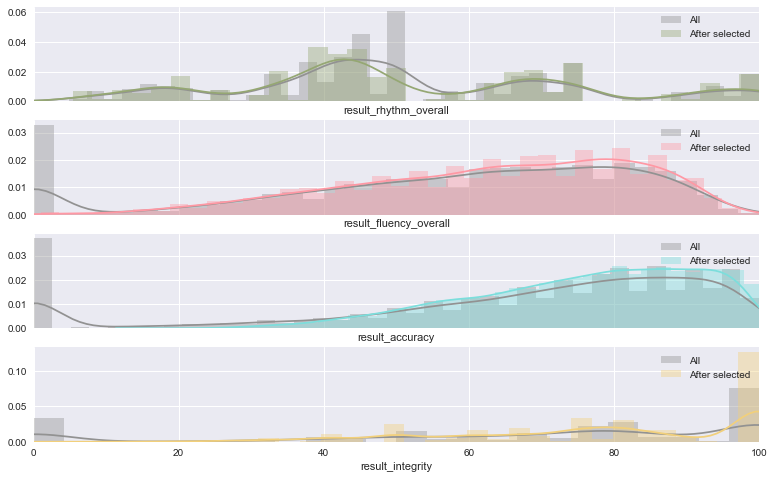

In [545]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 8), sharex=True)
plt.xlim(0, 100)

sns.distplot(df_engine.result_rhythm_overall,ax=ax1,color="#929292",label='All')
sns.distplot(df_good.result_rhythm_overall,ax=ax1, color="#95A773",label='After selected')

sns.distplot(df_engine.result_fluency_overall,ax=ax2,color="#929292",label='All')
sns.distplot(df_good.result_fluency_overall,ax=ax2, color="#FF98A4",label='After selected')

sns.distplot(df_engine.result_accuracy,ax=ax3,color="#929292",label='All')
sns.distplot(df_good.result_accuracy,ax=ax3, color="#7CDEDC",label='After selected')

sns.distplot(df_engine.result_integrity,ax=ax4,color="#929292",label='All')
sns.distplot(df_good.result_integrity,ax=ax4, color="#F2D07B",label='After selected')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

Text(0.5,1,u'Overall grade')

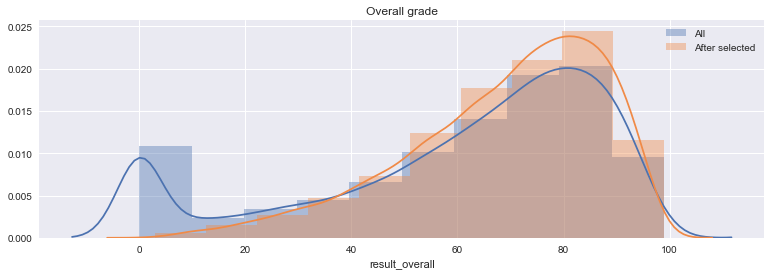

In [543]:
sns.distplot(df_engine.result_overall,label='All',bins=10)
sns.distplot(df_good.result_overall,label='After selected', color="#F08A47",bins=10)
plt.legend(loc='best')
plt.title('Overall grade')

Text(0.5,1,u'SNR')

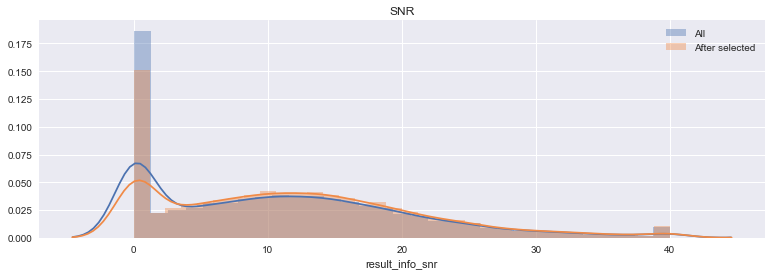

In [541]:
sns.distplot(df_engine.result_info_snr,label='All')
sns.distplot(df_good.result_info_snr,label='After selected', color="#F08A47")
plt.legend(loc='best')
plt.title('SNR')

Text(0.5,1,u'Volume')

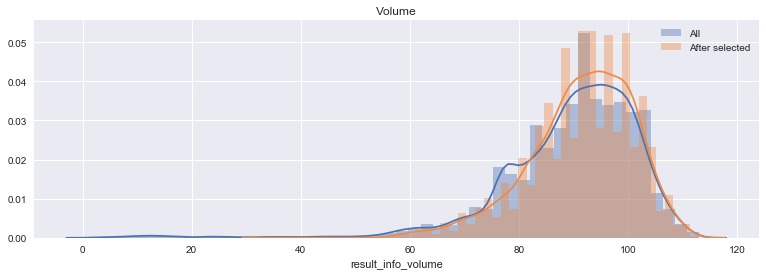

In [542]:
sns.distplot(df_engine.result_info_volume,label='All')
sns.distplot(df_good.result_info_volume,label='After selected', color="#F08A47")
plt.legend(loc='best')
plt.title('Volume')

In [730]:
df_engine.result_info_tipId.value_counts() / len(df_engine)

0.0        0.600734
10006.0    0.237329
10004.0    0.140675
10008.0    0.012353
10005.0    0.008909
Name: result_info_tipId, dtype: float64

In [731]:
df_good.result_info_tipId.value_counts() / len(df_engine)

0.0        0.555888
10006.0    0.202516
10004.0    0.077413
10008.0    0.011679
10005.0    0.008310
Name: result_info_tipId, dtype: float64

Text(0.5,1,u'Tip information')

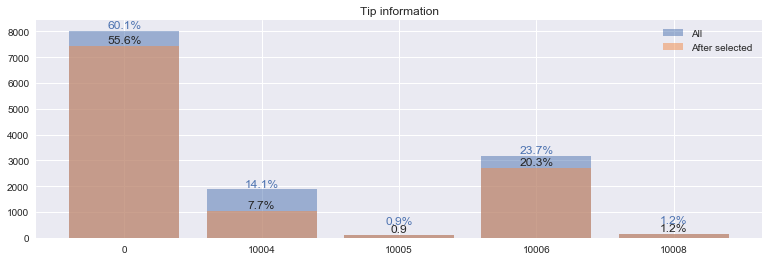

In [732]:
plt.bar(['0','10006','10004','10008','10005'],df_engine.result_info_tipId.value_counts().values,label='All',alpha=0.5)
plt.bar(['0','10006','10004','10008','10005'],df_good.result_info_tipId.value_counts().values, color="#F08A47",label='After selected',alpha=0.5)
plt.annotate('60.1%',[0,8124],horizontalalignment = 'center', color=sns.color_palette()[0])
plt.annotate('23.7%',[10006,3270],horizontalalignment = 'center', color=sns.color_palette()[0])
plt.annotate('14.1%',[10004,1979],horizontalalignment = 'center', color=sns.color_palette()[0])
plt.annotate('1.2%',[10008,565],horizontalalignment = 'center', color=sns.color_palette()[0])
plt.annotate('0.9%',[10005,519],horizontalalignment = 'center', color=sns.color_palette()[0])

plt.annotate('55.6%',[0,7525],horizontalalignment = 'center')
plt.annotate('20.3%',[10006,2805],horizontalalignment = 'center')
plt.annotate('7.7%',[10004,1134],horizontalalignment = 'center')
plt.annotate('1.2%',[10008,256],horizontalalignment = 'center')
plt.annotate('0.9',[10005,211],horizontalalignment = 'center')
plt.legend(loc='best')
plt.title('Tip information')

In [547]:
df_good.result_info_tipId.value_counts()

0.0        7425
10006.0    2705
10004.0    1034
10008.0     156
10005.0     111
Name: result_info_tipId, dtype: int64

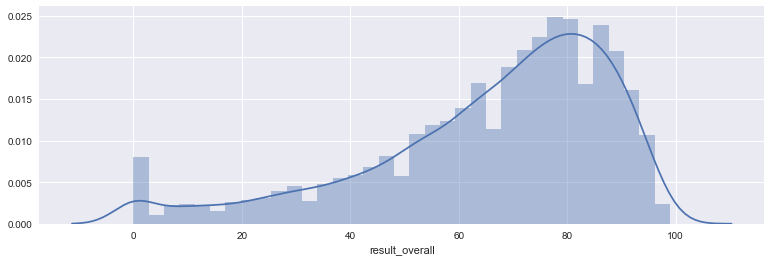

In [560]:
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall)

----------------

#新数据

In [593]:
df_engineNew = pd.read_csv('data/engine_details.csv').drop(['Unnamed: 0'],axis=1)

In [594]:
len(df_engineNew)

13509

In [595]:
# 去除NA的记录
df_engineNew = df_engineNew.dropna(axis=0,how='any')
df_engineNew = df_engineNew.reset_index().drop(['index'],axis=1)

In [596]:
len(df_engineNew)

13497

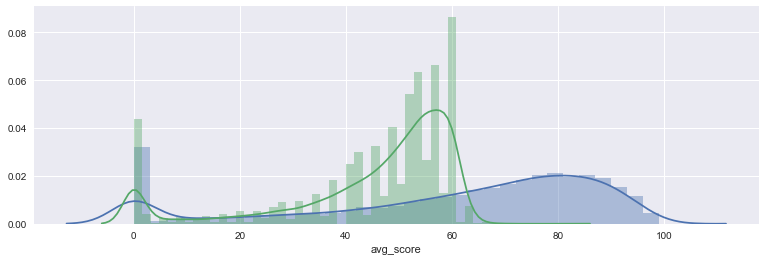

In [600]:
sns.distplot(df_engineNew.result_overall)
sns.distplot(df_engineNew.avg_score*20)

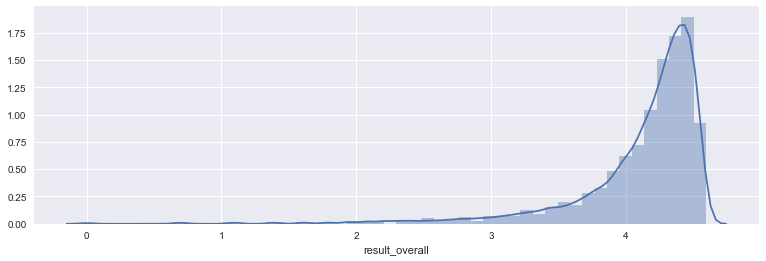

In [610]:

sns.distplot(np.log(df_engineNew[df_engineNew.result_overall !=0].result_overall))

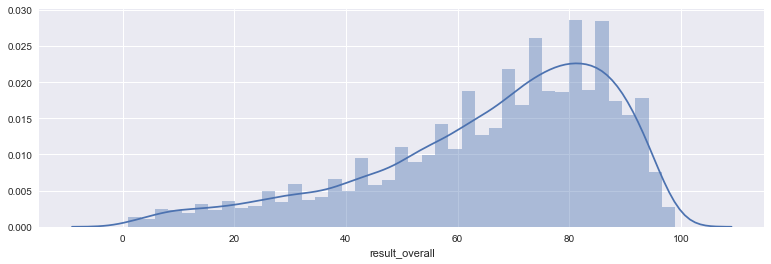

In [627]:
sns.distplot(df_engineNew[df_engineNew.result_overall !=0].result_overall)

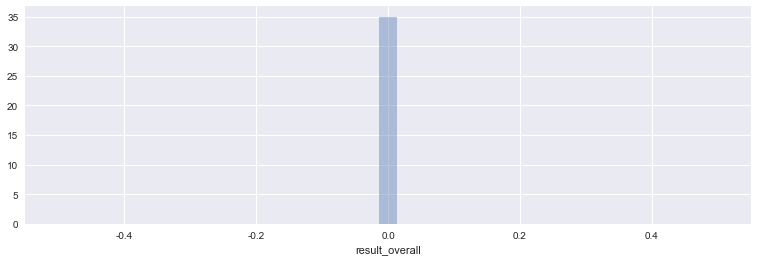

In [636]:
sns.distplot(df_engineNew[df_engineNew.result_overall ==0].result_overall)

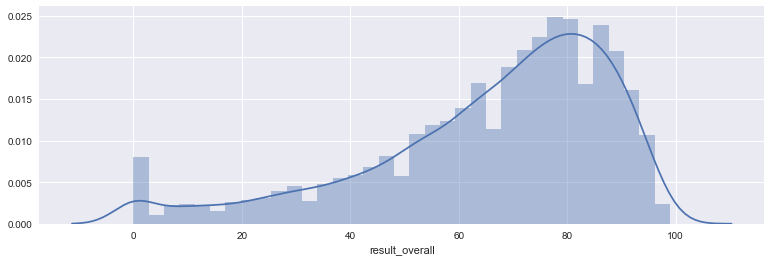

In [637]:
sns.distplot(df_engine[df_engine.result_info_tipId == 0].result_overall)

In [635]:
len(df_engine[df_engine.result_info_tipId == 0][df_engine.result_overall == 0]) / len(df_engine)

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


0.012502807516657933

In [629]:
df_engine[:2]

,refText,result_accuracy,result_fluency_overall,result_fluency_pause,result_fluency_speed,result_info_snr,result_info_tipId,result_info_volume,result_integrity,result_overall,result_rhythm_overall,result_rhythm_sense,result_rhythm_stress,result_rhythm_tone,result_wavetime
0,This is my grandma.,57.0,44.0,0.0,0.0,7.533660,0.0,90.0,60.0,46.0,13.0,0.0,50.0,0.0,3720.0
1,This is my uncle.,89.0,51.0,0.0,0.0,6.951506,0.0,89.0,100.0,80.0,38.0,50.0,50.0,0.0,3820.0


In [638]:
df_singSound = pd.read_csv('data/singSound_result&human.csv').drop(['Unnamed: 0'], axis=1)

In [641]:
len(df_singSound)

13509

In [643]:
from math import isnan

In [644]:
df_singSound = df_singSound.drop(df_singSound[[isnan(df_singSound.result_overall[i]) for i in range(len(df_singSound))]].index)

In [645]:
len(df_singSound)

13497

In [647]:
df_singSound[:2]

,refText,result_accuracy,result_fluency_overall,result_fluency_pause,result_fluency_speed,result_info_snr,result_info_tipId,result_info_volume,result_integrity,result_overall,result_rhythm_overall,result_rhythm_sense,result_rhythm_stress,result_rhythm_tone,result_wavetime,url,avg_score
0,"""This is my uncle.""",89.0,51.0,0.0,0.0,6.951506,0.0,89.0,100.0,80.0,38.0,50.0,50.0,0.0,3820.0,http://sas.alo7.com/audios/wav/10519676-cs-400...,2.7143
1,"""This is my uncle.""",93.0,52.0,0.0,0.0,14.115746,0.0,95.0,100.0,85.0,38.0,50.0,50.0,0.0,4230.0,http://sas.alo7.com/audios/wav/10519676-cs-400...,2.5714


NameError: name 'df_CS' is not defined

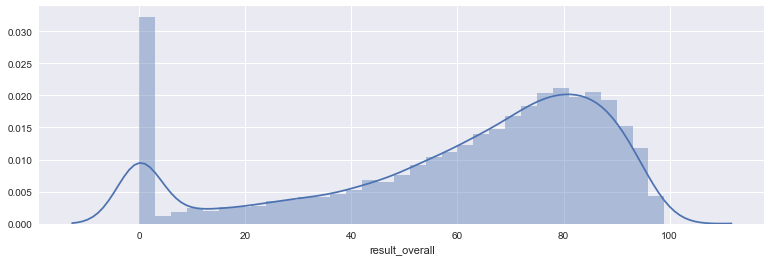

In [654]:
sns.distplot(df_singSound.result_overall,label='singSound')
sns.distplot(df_CS.ppScores, label='CS')
sns.distplot(df_singSound.avg_score * 25,color=sns.color_palette("Paired")[4],label="human")
plt.legend()
plt.title('')

In [652]:
(df_singSound.avg_score.min(),df_singSound.avg_score.max(),)

(0.0, 4.0)

In [ ]:
df_singSound.resu

In [748]:
df_singSound[df_singSound.result_info_tipId == 10006].result_info_snr.max()

6.4970690000000015

# 对比小于60分和大于60分的数据

事实上此处不仅需要以分值来进行区分,还需要考虑音质问题（提示信息）

In [660]:
df_engine_small60 = df_engine[df_engine.result_overall < 60]
df_engine_big60 = df_engine[df_engine.result_overall >= 60]

In [751]:
df_engine_small60_ok = df_engine_small60[df_engine_small60.result_info_tipId == 0]
df_engine_small60_not = df_engine_small60[df_engine_small60.result_info_tipId != 0]
df_engine_big60_ok = df_engine_big60[df_engine_big60.result_info_tipId == 0]
df_engine_big60_not = df_engine_big60[df_engine_big60.result_info_tipId != 0]

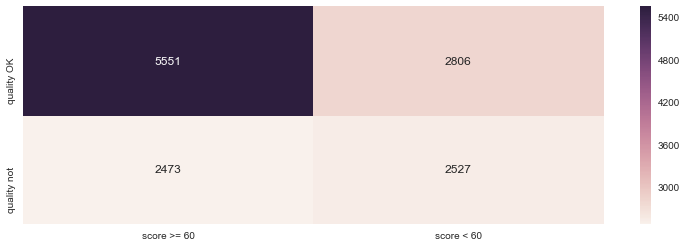

In [769]:
df_60_q = DataFrame(np.array([len(df_engine_big60_ok),len(df_engine_big60_not),
 len(df_engine_small60_ok),len(df_engine_small60_not)]).reshape(2,2))
df_60_q.index = ['quality OK', u'quality not']
df_60_q.columns = [u'score >= 60', u'score < 60']
sns.heatmap(df_60_q, annot=True, fmt='')

In [779]:
df_good = pd.concat([df_engine[df_engine.result_info_tipId == 0], df_engine_big60_not],axis=0)
df_bad = df_engine_small60_not

In [786]:
df_engine_ratio.index = ['good','bad']
df_engine_ratio.ratio = [len(df_good)/len(df_engine), len(df_bad)/len(df_engine)]

Text(0.9,0,u'18.9%')

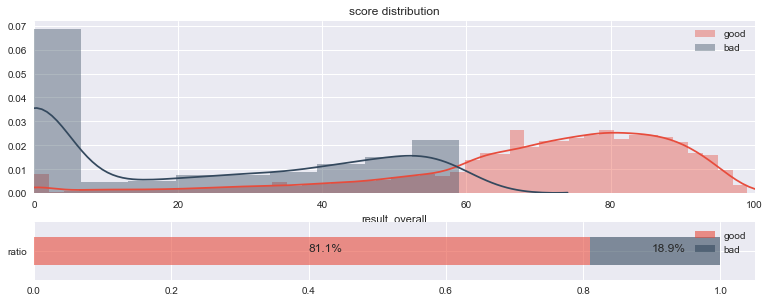

In [789]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]


ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

sns.distplot(df_good.result_overall, label='good',ax=ax1,color="#e74c3c")
sns.distplot(df_bad.result_overall, label='bad',ax=ax1,color="#34495e")
ax1.legend()
ax1.set_xlim(0,100)
ax1.set_title("score distribution")

df_engine_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=["#e74c3c","#34495e"], ax=ax2)
ax2.annotate('81.1%',[0.4,0])
ax2.annotate('18.9%',[0.9,0])

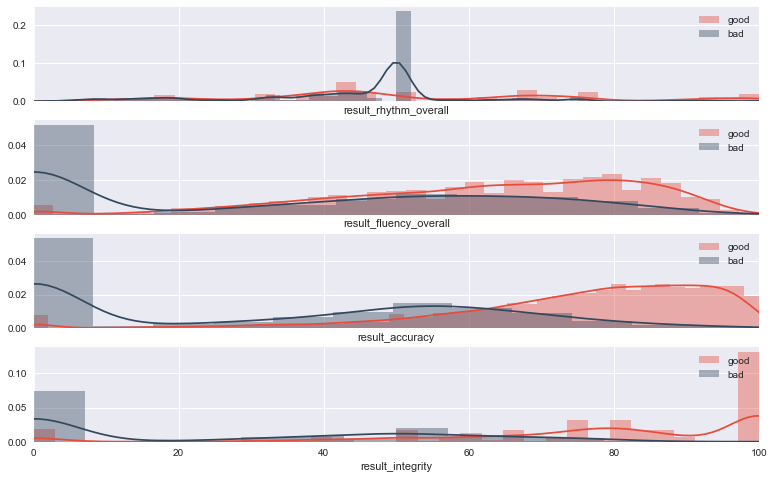

In [790]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 8), sharex=True)
plt.xlim(0, 100)

sns.distplot(df_good.result_rhythm_overall,ax=ax1,color="#e74c3c",label='good')
sns.distplot(df_bad.result_rhythm_overall,ax=ax1, color="#34495e",label='bad')

sns.distplot(df_good.result_fluency_overall,ax=ax2,color="#e74c3c",label='good')
sns.distplot(df_bad.result_fluency_overall,ax=ax2, color="#34495e",label='bad')

sns.distplot(df_good.result_accuracy,ax=ax3,color="#e74c3c",label='good')
sns.distplot(df_bad.result_accuracy,ax=ax3, color="#34495e",label='bad')

sns.distplot(df_good.result_integrity,ax=ax4,color="#e74c3c",label='good')
sns.distplot(df_bad.result_integrity,ax=ax4, color="#34495e",label='bad')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

Text(0.9,0,u'18.9%')

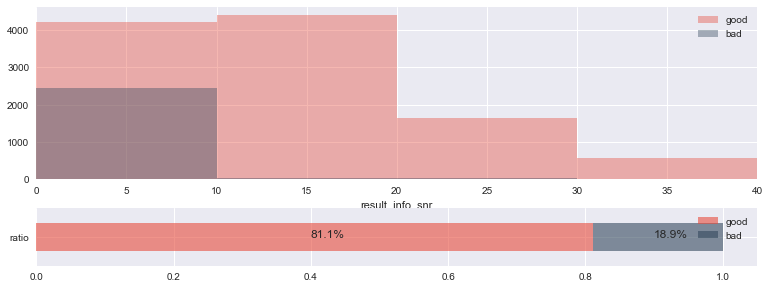

In [800]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)


sns.distplot(df_good.result_info_snr,bins=4, color="#e74c3c", label='good',kde=False, ax=ax1)
sns.distplot(df_bad.result_info_snr, bins=4,color="#34495e", label='bad' ,kde=False, ax=ax1)
ax1.legend(loc='best')
ax1.set_xlim(0,40)

df_engine_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=["#e74c3c","#34495e"], ax=ax2)
ax2.annotate('81.1%',[0.4,0])
ax2.annotate('18.9%',[0.9,0])

Text(0.9,0,u'18.9%')

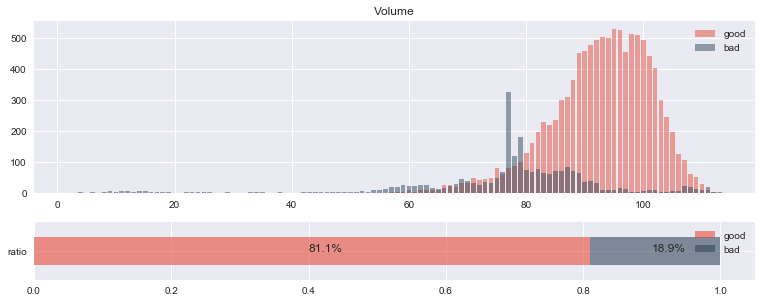

In [803]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)


ax1.bar(df_good.result_info_volume.value_counts().index, df_good.result_info_volume.value_counts().values, alpha=0.5,color="#e74c3c", label='good')
ax1.bar(df_bad.result_info_volume.value_counts().index, df_bad.result_info_volume.value_counts().values, label='bad', alpha=0.5, color="#34495e")
ax1.set_title('Volume')
ax1.legend(loc='best')

df_engine_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=["#e74c3c","#34495e"], ax=ax2)
ax2.annotate('81.1%',[0.4,0])
ax2.annotate('18.9%',[0.9,0])

In [807]:
df_bad.result_info_tipId.value_counts()

10006.0    1218
10004.0    1217
10008.0      57
10005.0      35
Name: result_info_tipId, dtype: int64

Text(0.9,0,u'18.9%')

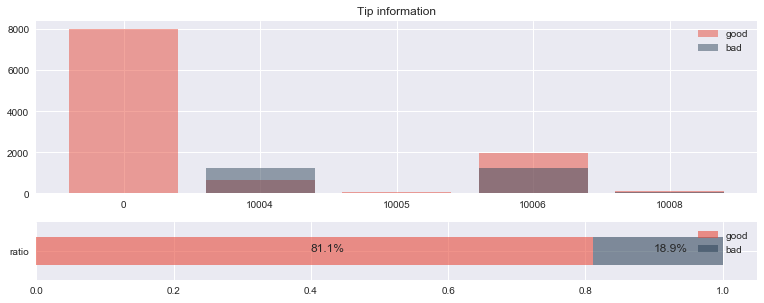

In [808]:
rect1 = [0.14, 0.35, 0.77, 0.6] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]

ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)


ax1.bar(['0','10006','10004','10008','10005'],df_good.result_info_tipId.value_counts().values,color="#e74c3c", label='good',alpha=0.5)
ax1.bar(['10006','10004','10008','10005'],df_bad.result_info_tipId.value_counts().values,color="#34495e", label='bad',alpha=0.5)
ax1.legend(loc='best')
ax1.set_title('Tip information')

df_engine_ratio.T.plot(kind='barh',stacked=True, alpha=0.6,color=["#e74c3c","#34495e"], ax=ax2)
ax2.annotate('81.1%',[0.4,0])
ax2.annotate('18.9%',[0.9,0])

In [810]:
df_tip = DataFrame()

df_tip['good'] = [len(df_good[df_good.result_info_tipId == 0]) / len(df_engine),
len(df_good[df_good.result_info_tipId == 10004]) / len(df_engine),
len(df_good[df_good.result_info_tipId == 10005]) / len(df_engine),
len(df_good[df_good.result_info_tipId == 10006]) / len(df_engine),
len(df_good[df_good.result_info_tipId == 10008]) / len(df_engine)
]

df_tip['bad'] = [len(df_bad[df_bad.result_info_tipId == 0]) / len(df_engine),
len(df_bad[df_bad.result_info_tipId == 10004]) / len(df_engine),
len(df_bad[df_bad.result_info_tipId == 10005]) / len(df_engine),
len(df_bad[df_bad.result_info_tipId == 10006]) / len(df_engine),
len(df_bad[df_bad.result_info_tipId == 10008]) / len(df_engine)
]

df_tip.index = ['0','10004','10005','10006','10008']

In [811]:
df_tip

,good,bad
0,0.600734,0.000000
10004,0.049562,0.091113
10005,0.006289,0.002620
10006,0.146141,0.091188
10008,0.008086,0.004267


Text(0.18,3,u'9.1%')

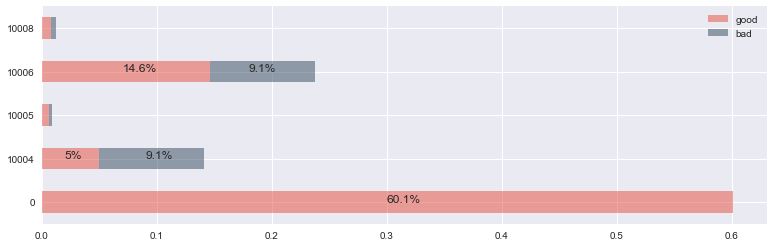

In [815]:
df_tip.plot(kind='barh', stacked=True, color=["#e74c3c", "#34495e"], alpha=0.5)
plt.annotate('60.1%',[0.3,0])
plt.annotate('5%',[0.02,1])
plt.annotate('9.1%',[0.09,1])
plt.annotate('14.6%',[0.07,3])
plt.annotate('9.1%',[0.18,3])